In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
import os
import warnings

# --- 1. 全局配置 (Global Configuration) ---

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_SEED = 42

# --- 檔案與路徑 ---
DATA_FILE = 'train.csv'
TARGET_COL = 'market_forward_excess_returns'
ID_COL = 'date_id'
RETURN_COL = 'forward_returns'
EXCLUDE_COLS = [TARGET_COL, ID_COL, RETURN_COL, 'risk_free_rate']

# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal 
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal 
SIGNAL_MULTIPLIER: float = 100.0                # Multiplier of the OLS forward returns predictions to signal

# ============ ROLLING TRAIN CONFIGS ============
WINDOW = 252
DELTA = 1
H = 1
PS_PERIODS = 20

# ============ XGB MODEL CONFIGS ============
N_ESTIMATORS = 500
LEARNING_RATE = 0.05
MAX_DEPTH = 4
MIN_CHILD_WEIGHT = 5
COLSAMPLE_BYTREE = 0.7

# *** 關鍵改動: 新的時間切分點 ***
START_DATE_ID = 6969          # 訓練數據實際起始點
VAL_START_ID = 8468           # 驗證集起始點 (8468 ~ 8867)
TEST_START_ID = 8868          # 測試集起始點 (8868 ~ 結束)

np.random.seed(RANDOM_SEED)

# =============================================================================
# 2. 數據集生成邏輯 (Feature Engineering)
# =============================================================================

def load_and_preprocess(filepath, start_id):
    """讀取、過濾並進行基礎處理"""
    print(f"Loading data from: {filepath}...")
    df = pd.read_csv(filepath)
    df = df.sort_values(ID_COL).reset_index(drop=True)

    # 過濾早期數據
    df = df[df[ID_COL] >= start_id].reset_index(drop=True)
    print(f"Data filtered to date_id >= {start_id}. New shape: {df.shape}")

    feature_cols = [c for c in df.columns if c not in EXCLUDE_COLS]

    # 2. 處理 'forward_returns' 的缺失值
    if df[RETURN_COL].isnull().any():
         df[RETURN_COL] = df[RETURN_COL].fillna(0)

    # 3. 清理 inf 值
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

    return df, feature_cols

def create_dataset_x(df, feature_cols):
    """Dataset x: Original features"""
    return df[feature_cols].copy()

def create_dataset_delta_x(df, feature_cols):
    """Dataset Δx: Percentage change features"""
    df_delta = pd.DataFrame()
    for col in feature_cols:
        pct_change = df[col].pct_change(fill_method=None)
        df_delta[f'pct_{col}'] = pct_change.replace([np.inf, -np.inf], 0).fillna(0)
    df_delta = df_delta.fillna(0)
    return df_delta

def create_dataset_r(df: pd.DataFrame, lags: int = 60, cumulative_window_max: int = 60) -> pd.DataFrame:
    """
    Dataset r: Historical Log Returns (Single U Cumulative)
    """

    realized_return_simple = df[RETURN_COL].shift(1)
    realized_return_log = np.log1p(realized_return_simple)
    realized_return_log = realized_return_log.replace([np.inf, -np.inf], np.nan).fillna(0)

    new_features = {}

    # 1. 生成 lags 個單日滯後對數回報
    for i in range(lags):
        new_features[f'log_return_single_lag{i+1}'] = realized_return_log.shift(i).fillna(0)

    # 2. 生成 cumulative_window_max 個累積對數回報
    for w in range(1, cumulative_window_max + 1):
        new_features[f'log_return_cum_{w}d'] = realized_return_log.rolling(window=w).sum().fillna(0)

    df_r = pd.DataFrame(new_features)

    return df_r

def generate_all_datasets(df, x_cols):
    """生成並組合 5 種數據集"""
    ds_x = create_dataset_x(df, x_cols)
    ds_delta_x = create_dataset_delta_x(df, x_cols)
    ds_r = create_dataset_r(df)

    r_features = [c for c in ds_r.columns]

    # Dataset 4: x ∪ r
    ds_4 = pd.concat([ds_x, ds_r[r_features]], axis=1)

    # Dataset 5: Δx ∪ r
    ds_5 = pd.concat([ds_delta_x, ds_r[r_features]], axis=1)


    return {
        '1_Original_x': ds_x,
        '2_PctChange_Δx': ds_delta_x,
        '3_Historical_r': ds_r,
        '4_Original+r': ds_4,
        '5_PctChange+r': ds_5
    }

In [2]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Handle data
import polars as pl
import pandas as pd
import numpy as np

# Dataclasses
from dataclasses import dataclass, asdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 6)

# Model and evaluation
from powershap import PowerShap
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import root_mean_squared_error, accuracy_score, r2_score, confusion_matrix

# Typing
from typing import Literal
from sklearn.base import RegressorMixin, ClassifierMixin

# Progress bar
from tqdm import tqdm

# Introspection
import inspect

# File system
from pathlib import Path
import os

In [3]:
# ============ PATHS ============
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    DATA_PATH: Path = Path('/kaggle/input/hull-tactical-market-prediction/')
else:
    DATA_PATH: Path = Path('./')
    


In [4]:
@dataclass
class DatasetOutput:
    X_train : pl.DataFrame 
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    i_train: pl.Series
    i_test: pl.Series
    
@dataclass
class NamedDatasetOutput:
    name: str
    X: pl.DataFrame
    y: pl.Series
    index: pl.Series
        
@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float = 100
    min_signal : float = 0
    max_signal : float = 2

In [5]:
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "train.csv")
        .rename({'forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
    )

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
    )

def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]
    
    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical").group_by('date_id', maintain_order=True).agg(pl.all().first())

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput: 
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model. 

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.drop(['date_id','target']).select(features)
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target']).select(features)
    y_test = test.get_column('target')
    i_train = train.get_column('date_id')
    i_test = test.get_column('date_id')
    
    return DatasetOutput(
        X_train = X_train,
        y_train = y_train, 
        X_test = X_test, 
        y_test = y_test,
        i_train = i_train,
        i_test = i_test
    )

In [6]:
def get_model_type(model: RegressorMixin | ClassifierMixin) -> Literal['classifier', 'regressor']:
    return model._estimator_type

def get_result_path(dataset_name: str, window: int, delta: int, h: int, model: RegressorMixin | ClassifierMixin, category: str) -> Path:
    model_name = model.__class__.__name__
    return Path('results') / dataset_name / f'window={window}&delta={delta}&h={h}' / model_name / f'{category}.csv'

def save_result_csv(dataset_name: str, window: int, delta: int, h: int, model: RegressorMixin | ClassifierMixin, category: str, data: pl.DataFrame | pl.Series) -> None:
    path = get_result_path(dataset_name, window, delta, h, model, category)
    path.parent.mkdir(parents=True, exist_ok=True)
    data.write_csv(path)

def get_result_csv(dataset_name: str, window: int, delta: int, h: int, model: RegressorMixin | ClassifierMixin, category: str) -> pl.DataFrame | None:
    path = get_result_path(dataset_name, window, delta, h, model, category)
    return pl.read_csv(path) if path.exists() else None

def get_pred_csv(dataset_name: str, window: int, delta: int, h: int, model: RegressorMixin | ClassifierMixin) -> tuple[pl.Series, pl.Series, pl.Series, pl.Series]:
    base_pred_df = get_result_csv(dataset_name, window, delta, h, model, 'base_pred')
    index = base_pred_df.get_column('date_id')
    base_pred = base_pred_df.get_column('base_pred')
    
    mask = ~base_pred.is_nan()
    index = index.filter(mask)
    base_pred = base_pred.filter(mask)
    ps_pred = get_result_csv(dataset_name, window, delta, h, model, 'ps_pred').get_column('ps_pred').filter(mask)
    y_true = get_result_csv(dataset_name, window, delta, h, model, 'y_true').get_column('y_true').filter(mask)
    
    return index, y_true, base_pred, ps_pred

def rolling_train(data: NamedDatasetOutput, window: int, delta: int, h: int, model: RegressorMixin | ClassifierMixin, ps_periods: int = 20) -> None:
    dataset_name: str = data.name
    X: pl.DataFrame = data.X
    y: pl.Series = data.y
    index: pl.Series = data.index
    
    # if get_result_csv(dataset_name, window, delta, h, model, 'y_true') is not None:
    #     return
    
    model_type: Literal['classifier', 'regressor'] = get_model_type(model)
    model_name: str = model.__class__.__name__

    # h-day forward returns as target
    # (1+r1)*(1+r2)... - 1  <=>  exp(ln(1+r1) + ln(1+r2) + ...) - 1
    y = ((1 + y).log().rolling_sum(window_size=h).exp() - 1).shift(-h + 1)
    
    if model_type == 'classifier':
        y = (y > 0).cast(pl.Int8)
    
    # Total time points
    T = X.height

    # Number of iterations
    K = int((T - (window + 2 * h + delta)) / delta)

    # Conduct PowerShap every ps_periods
    ps_iter_periods = int(ps_periods / delta)
    ps_cooldown = 0
    
    # Storage for results
    preds_list: list[dict[str, np.ndarray]] = []
    impacts_list: list[dict[str, int | float]] = []
    n_feats_list: list[dict[str, int]] = []
    feats_selected_list: list[dict[str, int | set]] = []
    
    # PowerShap selector and selected features
    selector = None
    feats = []
    
    # Check if model.fit supports verbose parameter
    fit_params = inspect.signature(model.fit).parameters
    fit_kwargs = {'verbose': 0} if 'verbose' in fit_params else {}

    for k in tqdm(range(K), desc=f'Processing {model_name} on {dataset_name} with window={window}, delta={delta}, h={h}'):
        t = k * delta
        
        # Define slices
        # Train: [t, t + window)
        # Test: [t + window + h, t + window + h + delta)
        
        # Polars slicing
        X_train = X.slice(t, window)
        y_train = y.slice(t, window)
        
        # Test set
        test_offset = t + window + h
        X_test = X.slice(test_offset, delta)
        y_test = y.slice(test_offset, delta)
        current_test_index = index.slice(test_offset, delta)
        
        if any(X_train.null_count().sum_horizontal() > 0):
            preds_list.append(pl.DataFrame({
                'date_id': current_test_index,
                'y_true': y_test,
                'base_pred': [None]*delta,
                'ps_pred': [None]*delta
            }))
            ps_cooldown -= 1
            continue
        
        # Current evaluation time (for logging)
        eval_time = index[test_offset] if test_offset < index.len() else None
        
        # Fit PowerShap periodically
        if ps_cooldown <= 0:
            ps_cooldown = ps_iter_periods
            
            selector = PowerShap(
                model = model,
                automatic=True,
                verbose=0,
                show_progress=False
            )
            # Convert to pandas for PowerShap compatibility
            selector.fit(X_train, y_train, **fit_kwargs)
            
            feats = selector.get_feature_names_out()
            
            # Store selected features
            feats_selected_list.append({'date_id': eval_time, 'selected_features': set(feats)})

            # Store n_feats
            n_feats_list.append({'date_id': eval_time, 'n_feats': len(feats)})
            
            # Store impacts
            impact = selector._processed_shaps_df['impact'].drop(index=['random_uniform_feature'])
            impact_dict = {'date_id': eval_time}
            impact_dict.update(impact.to_dict())
            impacts_list.append(impact_dict)
        
        # Skip if not enough classes for classifier or no features selected
        if model_type == 'classifier' and y_train.n_unique() < 2 or len(feats) == 0:
            preds_list.append(pl.DataFrame({
                'date_id': current_test_index,
                'y_true': y_test,
                'base_pred': [None]*delta,
                'ps_pred': [None]*delta
            }))
            ps_cooldown -= 1
            continue
        
        # Predictions
        # Base model (all valid features)
        model.fit(X_train, y_train, **fit_kwargs)
        base_p = model.predict(X_test)
        
        # PowerShap model (selected features)
        model.fit(X_train.select(feats), y_train, **fit_kwargs)
        ps_p = model.predict(X_test.select(feats))
        
        # Store predictions
        preds_list.append(pl.DataFrame({
            'date_id': current_test_index,
            'y_true': y_test,
            'base_pred': base_p,
            'ps_pred': ps_p
        }))
        
        ps_cooldown -= 1
            
    # Aggregate Results
    
    # 1. Predictions
    all_preds = pl.concat(preds_list, how='vertical_relaxed')
    y_true = all_preds.select(['date_id', 'y_true'])
    base_pred = all_preds.select(['date_id', 'base_pred'])
    ps_pred = all_preds.select(['date_id', 'ps_pred'])

    # 2. Impacts
    impacts = pl.from_dicts(impacts_list).fill_null(0)
    # Calculate ratios
    row_sums = impacts.select(pl.exclude('date_id')).sum_horizontal()
    impacts_ratios = impacts.with_columns(
        pl.exclude('date_id') / row_sums
    )

    # 3. n_feats
    n_feats = pl.from_dicts(n_feats_list)
    
    # 4. selected features
    feats_selected_data = []
    for item in feats_selected_list:
        row = {'date_id': item['date_id']}
        for feat in X.columns:
            row[feat] = feat in item['selected_features']
        feats_selected_data.append(row)
    feats_selected = pl.from_dicts(feats_selected_data)
    
    # Save results
    for category, values in zip(
        ['y_true', 'base_pred', 'ps_pred', 'impacts', 'impacts_ratios', 'n_feats', 'feats_selected'],
        [y_true, base_pred, ps_pred, impacts, impacts_ratios, n_feats, feats_selected]
    ):
        save_result_csv(dataset_name, window, delta, h, model, category, values)
        
def evaluate(dataset_name: str, window: int, delta: int, h: int, model):
    _, y_true, base_pred, ps_pred = get_pred_csv(dataset_name, window, delta, h, model)
    
    metrics = {
        'RMSE': root_mean_squared_error,
        'Accuracy': accuracy_score
    }
    metric = 'RMSE' if get_model_type(model) == 'regressor' else 'Accuracy'
    metric_fn = metrics[metric]
    scores = metric_fn(y_true, base_pred), metric_fn(y_true, ps_pred)
    
    model_name = model.__class__.__name__
    print(f'{model_name} {metric}: {scores[0]:.6f}')
    print(f'{model_name} with PowerShap {metric}: {scores[1]:.6f}')
    print('---')
    
    return scores

def plot_results(dataset_name, window, delta, h, model):
    _, y_true, base_pred, ps_pred = get_pred_csv(dataset_name, window, delta, h, model)
    
    model_name = model.__class__.__name__
    
    if get_model_type(model) == 'regressor':
        # Scatter plot with r2 score
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=y_true, y=base_pred)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.title(rf'All Features, $R^2$: {r2_score(y_true, base_pred):.4f}')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=y_true, y=ps_pred)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.title(rf'PowerShap Selected Features, $R^2$: {r2_score(y_true, ps_pred):.4f}')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        
        plt.suptitle(f'{model_name} Predictions vs True Values')
        plt.show()
    else:
        # Confusion matrix
        cm_base = confusion_matrix(y_true, base_pred)
        cm_ps = confusion_matrix(y_true, ps_pred)
        
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
        plt.title('All Features Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(cm_ps, annot=True, fmt='d', cmap='Blues')
        plt.title('PowerShap Selected Features Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        plt.suptitle(f'{model_name} Confusion Matrices')
        plt.show()
    
def plot_feature_impacts(dataset_name, window, delta, h, model, n_feat_lineplot=True, n_feat_boxplot=True, impacts_barplot=True, impacts_ratios_barplot=True, impacts_over_time=True, impacts_ratios_over_time=True):
    n_feats_df = get_result_csv(dataset_name, window, delta, h, model, 'n_feats')
    index = n_feats_df.get_column('date_id')
    n_feats = n_feats_df.get_column('n_feats')
    impacts = get_result_csv(dataset_name, window, delta, h, model, 'impacts')
    impacts_ratios = get_result_csv(dataset_name, window, delta, h, model, 'impacts_ratios')
    
    avg_impacts = impacts.select(pl.exclude('date_id')).median().transpose(include_header=True).sort(by='column_0', descending=True).head(10)
    avg_impacts_ratios = impacts_ratios.select(pl.exclude('date_id')).median().transpose(include_header=True).sort(by='column_0', descending=True).head(10)
    
    desc = f'model={model.__class__.__name__}, window={window}, delta={delta}, h={h}'
    
    if n_feat_lineplot:
        # Number of features over time
        plt.figure(figsize=(16, 6))
        sns.lineplot(x=index, y=n_feats, legend=False)
        plt.title(f'Number of Selected Features Over Time ({desc})')
        plt.xlabel(index.name)
        plt.ylabel('Number of Features')
        plt.show()
    
    if n_feat_boxplot:
        # Number of features box plot
        plt.figure(figsize=(6, 6))
        sns.boxplot(data=n_feats)
        plt.title(f'Number of Selected Features Distribution ({desc})')
        plt.xlabel('Features')
        plt.ylabel('Number of Features')
        plt.show()
    
    if impacts_barplot:
        # Median impacts bar plot
        plt.figure(figsize=(16, 6))
        sns.barplot(x=avg_impacts.get_column('column'), y=avg_impacts.get_column('column_0'))
        plt.xticks(rotation=90)
        plt.title(f'Median Feature Impacts ({desc})')
        plt.xlabel('Features')
        plt.ylabel('Median Impact')
        plt.show()
    
    if impacts_ratios_barplot:
        # Median impact ratios bar plot
        plt.figure(figsize=(16, 6))
        sns.barplot(x=avg_impacts_ratios.get_column('column'), y=avg_impacts_ratios.get_column('column_0'))
        plt.xticks(rotation=90)
        plt.title(f'Median Feature Impact Ratios ({desc})')
        plt.xlabel('Features')
        plt.ylabel('Median Impact Ratio')
        plt.show()
    
    if impacts_over_time:
        # Impact over time
        max_impacts = impacts.max()
        top_10_features = max_impacts.select(pl.exclude('date_id')).transpose(include_header=True).sort(by='column_0', descending=True).head(10).get_column('column')
        plt.figure(figsize=(15, 8))
        for col in top_10_features:
            line = plt.plot(index, impacts.get_column(col), label=col)
            max_val = impacts.get_column(col).max()
            max_idx = index[impacts.get_column(col).arg_max()]
            plt.text(max_idx, max_val, col, color=line[0].get_color())
        plt.title(f'Feature Impacts Over Time ({desc})')
        plt.xlabel(index.name)
        plt.ylabel('Impact')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
    
    if impacts_ratios_over_time:
        # Impact ratios over time
        max_ratios = impacts_ratios.max()
        top_10_features_ratios = max_ratios.select(pl.exclude('date_id')).transpose(include_header=True).sort(by='column_0', descending=True).head(10).get_column('column')
        plt.figure(figsize=(15, 8))
        for col in top_10_features_ratios:
            line = plt.plot(index, impacts_ratios.get_column(col), label=col)
            max_val = impacts_ratios.get_column(col).max()
            max_idx = index[impacts_ratios.get_column(col).arg_max()]
            plt.text(max_idx, max_val, col, color=line[0].get_color())
        plt.title(f'Feature Impact Ratios Over Time ({desc})')
        plt.xlabel(index.name)
        plt.ylabel('Impact Ratio')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [7]:
pandas_df, feature_cols = load_and_preprocess(DATA_FILE, START_DATE_ID)
all_datasets = generate_all_datasets(pandas_df, feature_cols)
all_datasets['1_Original_x'].tail(5)

Loading data from: train.csv...
Data filtered to date_id >= 6969. New shape: (2052, 98)


D1  D2  D3  D4  D5  D6  D7  D8  D9        E1  ...       V12       V13  \
2047   0   0   0   1   0   0   0   0   0  1.493117  ...  0.359788 -0.251129   
2048   0   0   0   1   0   0   0   0   0  1.490889  ...  0.340939 -0.277774   
2049   0   0   0   1   0  -1   0   0   0  1.488667  ...  0.271825 -0.188326   
2050   0   0   0   1   0  -1   0   0   0  1.486451  ...  0.294974 -0.354068   
2051   0   0   0   1   0  -1   0   0   0  1.484241  ...  0.195106 -0.444627   

            V2        V3        V4        V5        V6        V7        V8  \
2047  0.541005  0.208995  0.484788  0.717308  0.677249 -0.327455  0.083995   
2048  0.507937  0.082011  0.482804  1.001028  0.596561 -0.372979  0.094246   
2049  0.474868  0.334656  0.486772  0.894502  0.656746 -0.282024  0.090608   
2050  0.467593  0.163360  0.492725  1.117639  0.674603 -0.445261  0.106481   
2051  0.437831  0.177910  0.501323  1.231340  0.486111 -0.562036  0.089947   

            V9  
2047 -0.380452  
2048 -0.427355  
2049 -0.381337  
2050 -0.477635  
2051 -0.543367  

[5 rows x 94 columns]

In [8]:
df = pl.from_pandas(pandas_df).select([ID_COL, TARGET_COL] + feature_cols)
y = df.get_column(TARGET_COL)
index = df.get_column(ID_COL)

linear_reg = LinearRegression()
xgb = XGBRegressor(
    n_estimators=N_ESTIMATORS,
    learning_rate=LEARNING_RATE,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    colsample_bytree=COLSAMPLE_BYTREE,
    random_state=RANDOM_SEED,
    verbosity=0
)

for name, dataset in all_datasets.items():
    named_dataset = NamedDatasetOutput(
        name=name,
        X=pl.from_pandas(dataset),
        y=y,
        index=index
    )
    
    for model in [linear_reg, xgb]:
        rolling_train(
            data=named_dataset,
            window=WINDOW,
            delta=DELTA,
            h=H,
            model=model,
            ps_periods=PS_PERIODS
        )

Processing LinearRegression on 1_Original_x with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [01:24<00:00, 21.37it/s]
Processing XGBRegressor on 1_Original_x with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [13:37<00:00,  2.20it/s]
Processing LinearRegression on 2_PctChange_Δx with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [01:03<00:00, 28.30it/s]
Processing XGBRegressor on 2_PctChange_Δx with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [16:33<00:00,  1.81it/s] 
Processing LinearRegression on 3_Historical_r with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [01:18<00:00, 22.92it/s]
Processing XGBRegressor on 3_Historical_r with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [13:51<00:00,  2.16it/s] 
Processing LinearRegression on 4_Original+r with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [01:34<00:00, 19.10it/s]
Processing XGBRegressor on 4_Original+r with window=252, delta=1, h=1: 100%|██████████| 1797/1797 [18:46<00:00,  

In [9]:
from Metric import analyze_returns
def convert_ret_to_signal(
    ret_arr: np.ndarray,
) -> np.ndarray:
    """
    Converts raw model predictions (returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * SIGNAL_MULTIPLIER + 1, MIN_SIGNAL, MAX_SIGNAL
    )

LinearRegression RMSE: 0.019847
LinearRegression with PowerShap RMSE: 0.015932
---


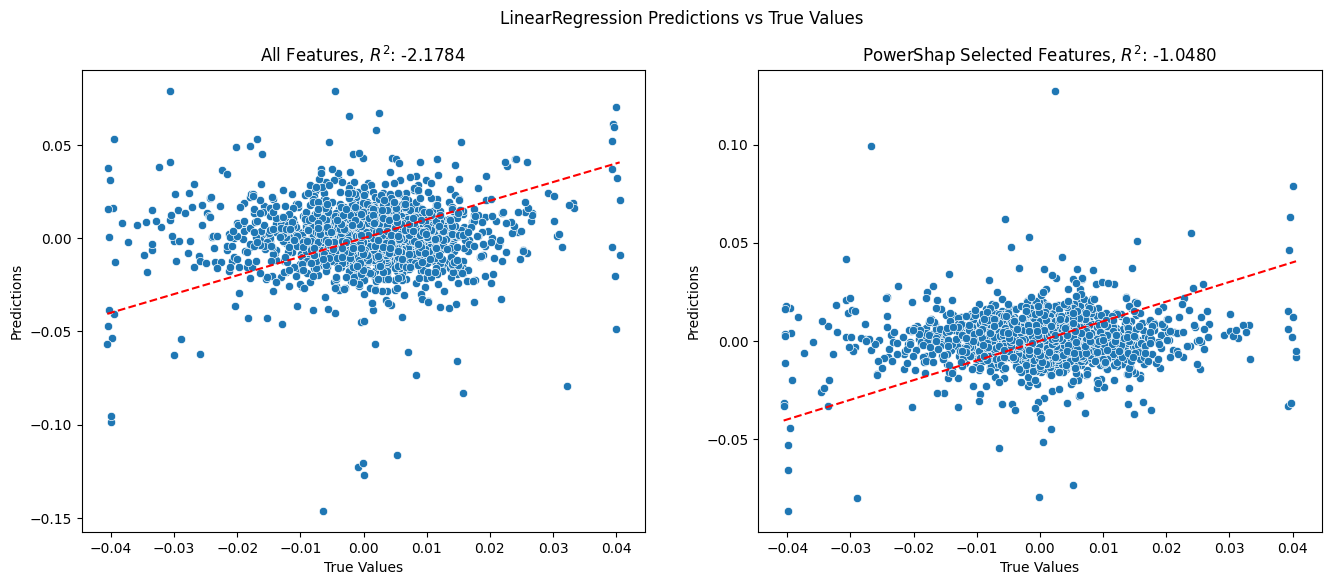

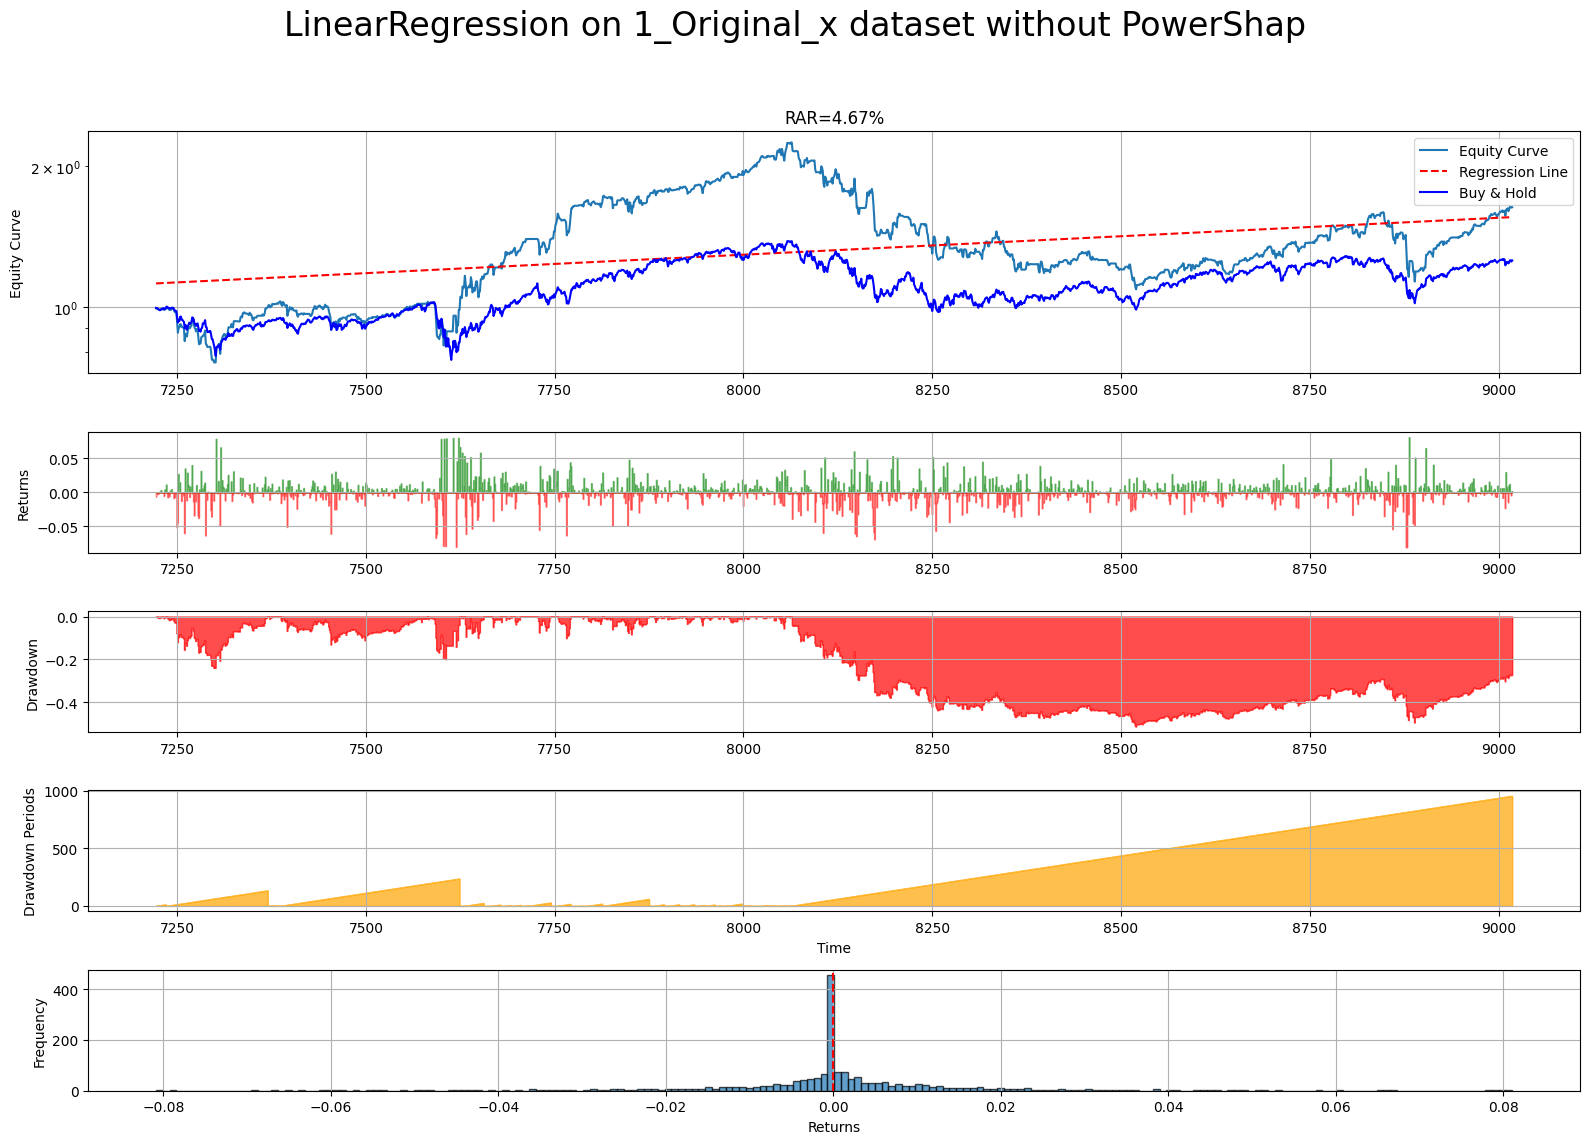

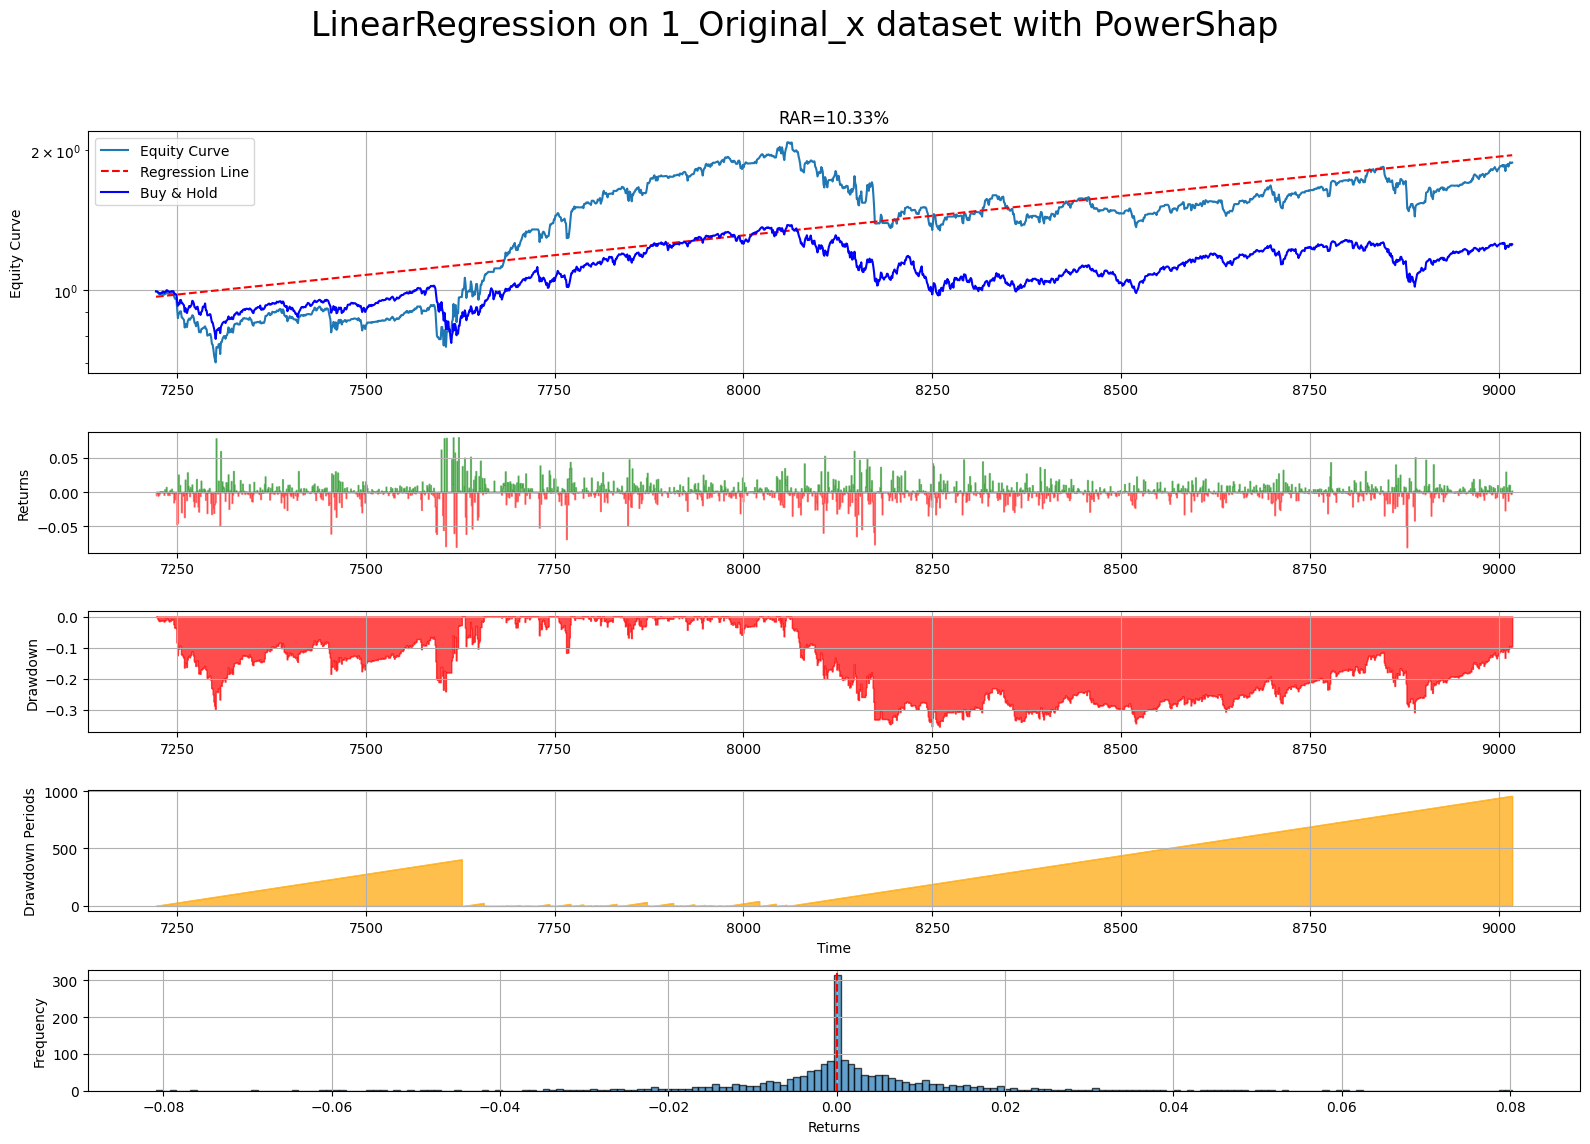

XGBRegressor RMSE: 0.011789
XGBRegressor with PowerShap RMSE: 0.012662
---


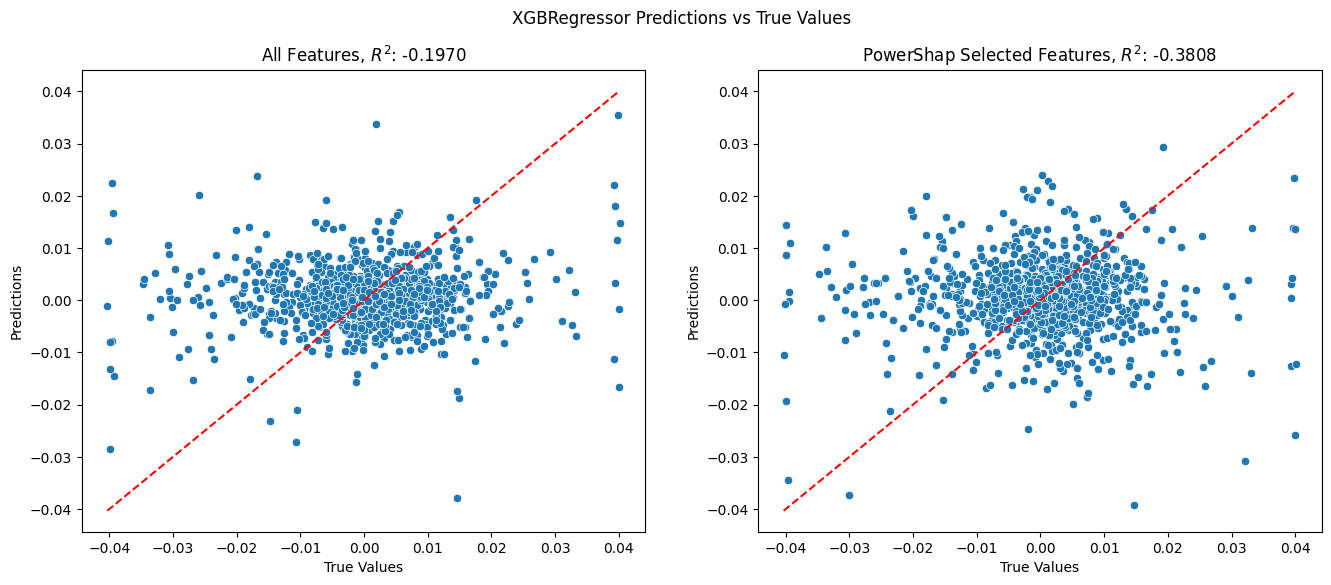

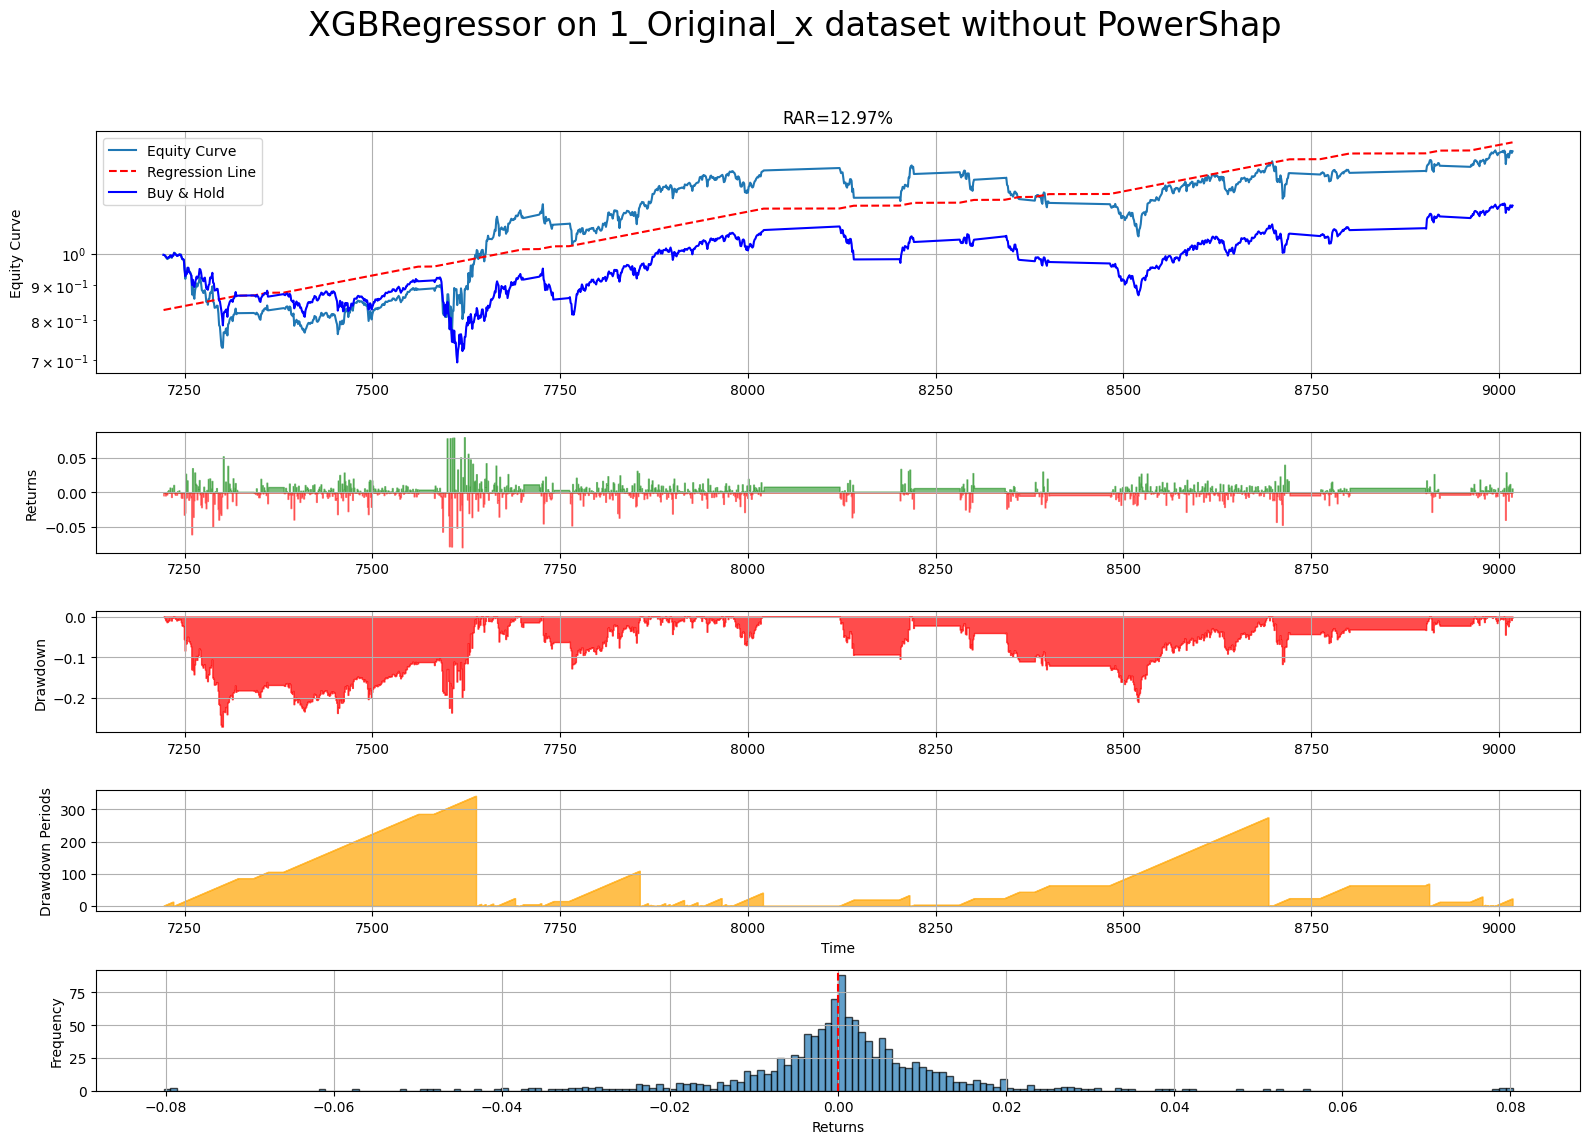

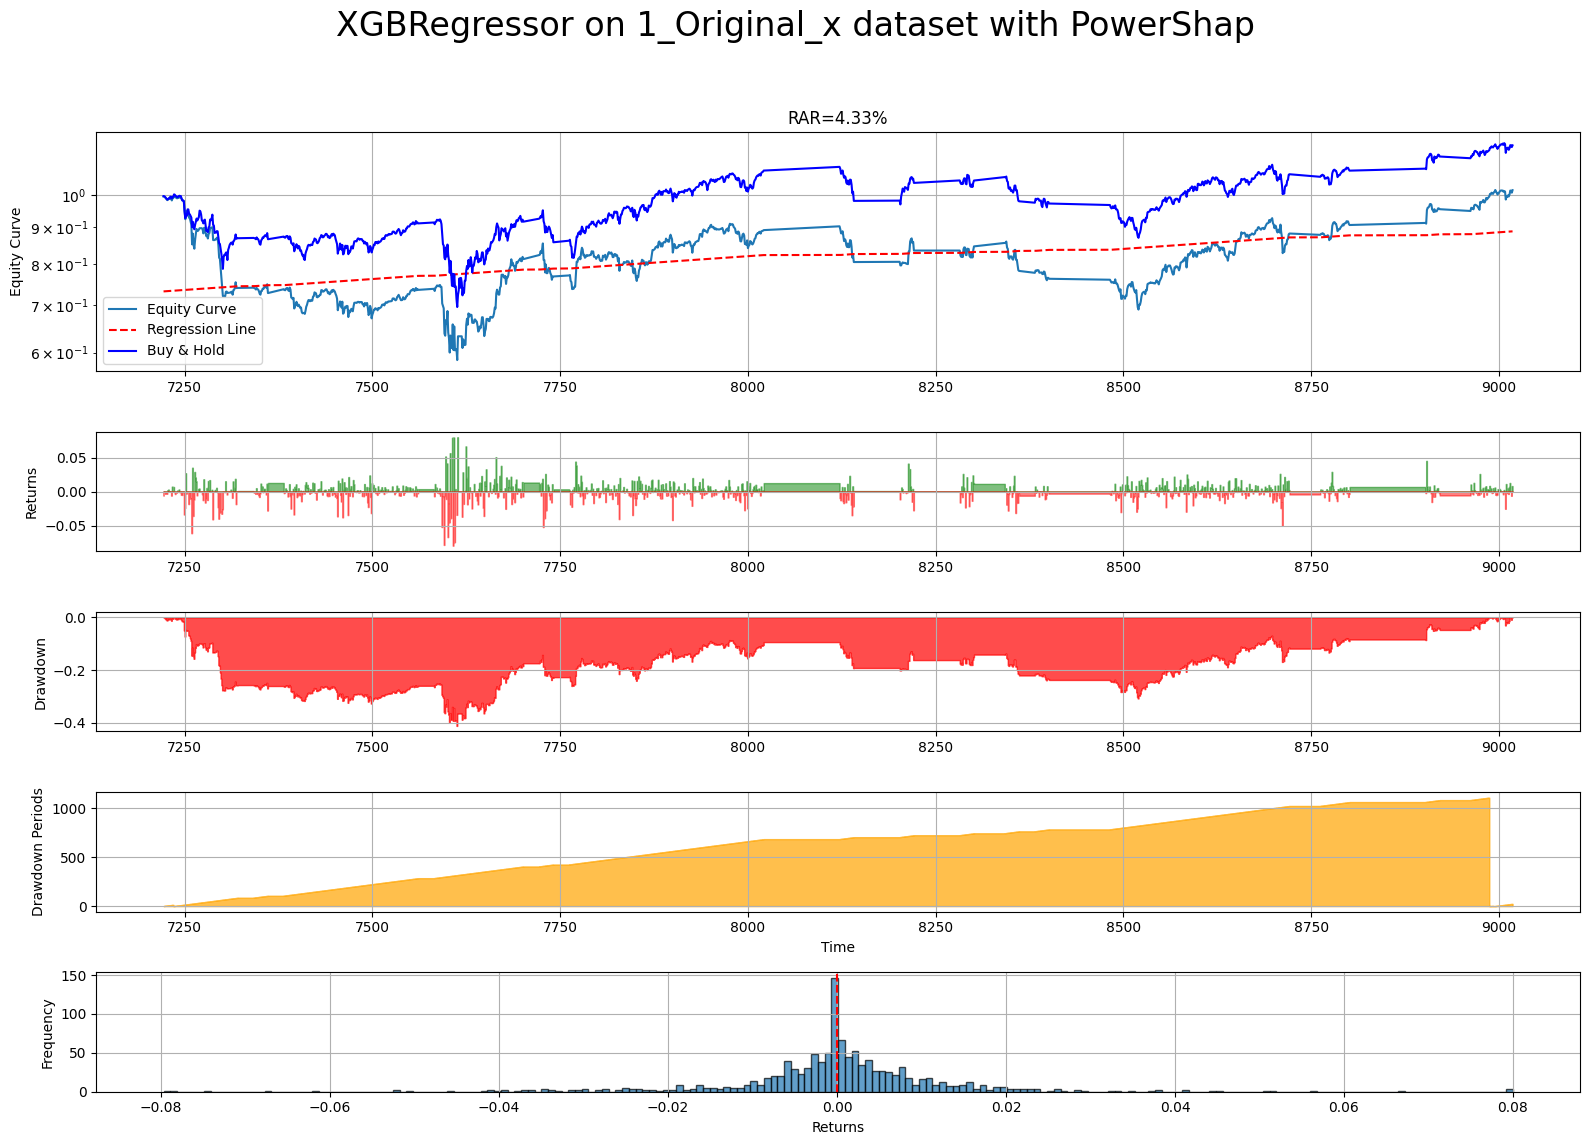

LinearRegression RMSE: 0.268335
LinearRegression with PowerShap RMSE: 0.039333
---


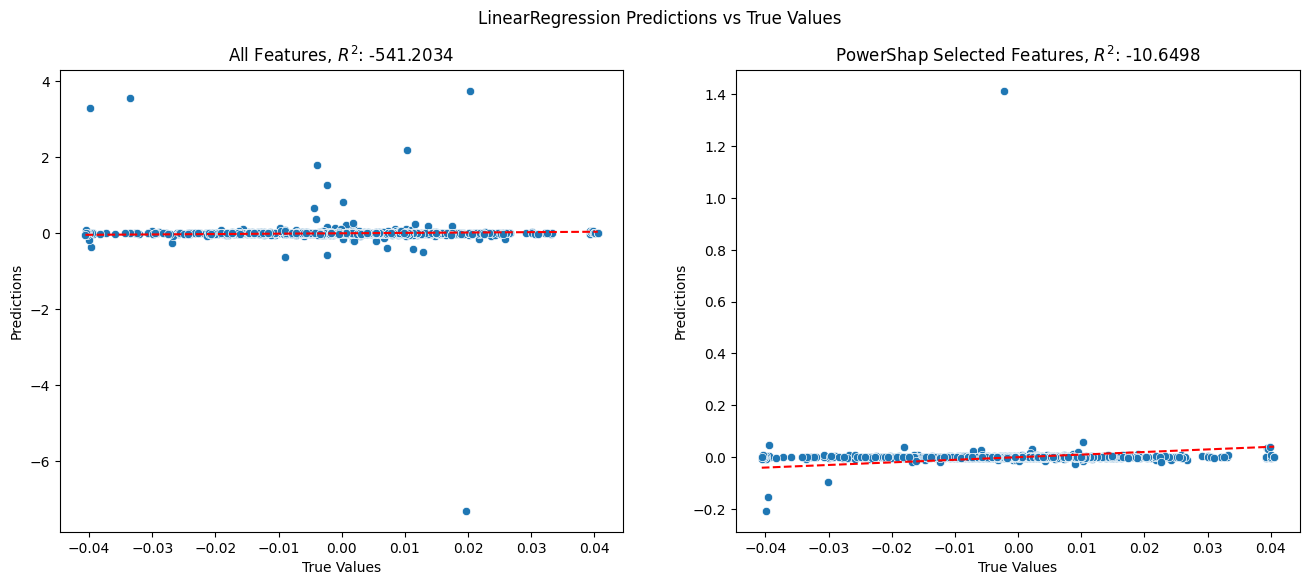

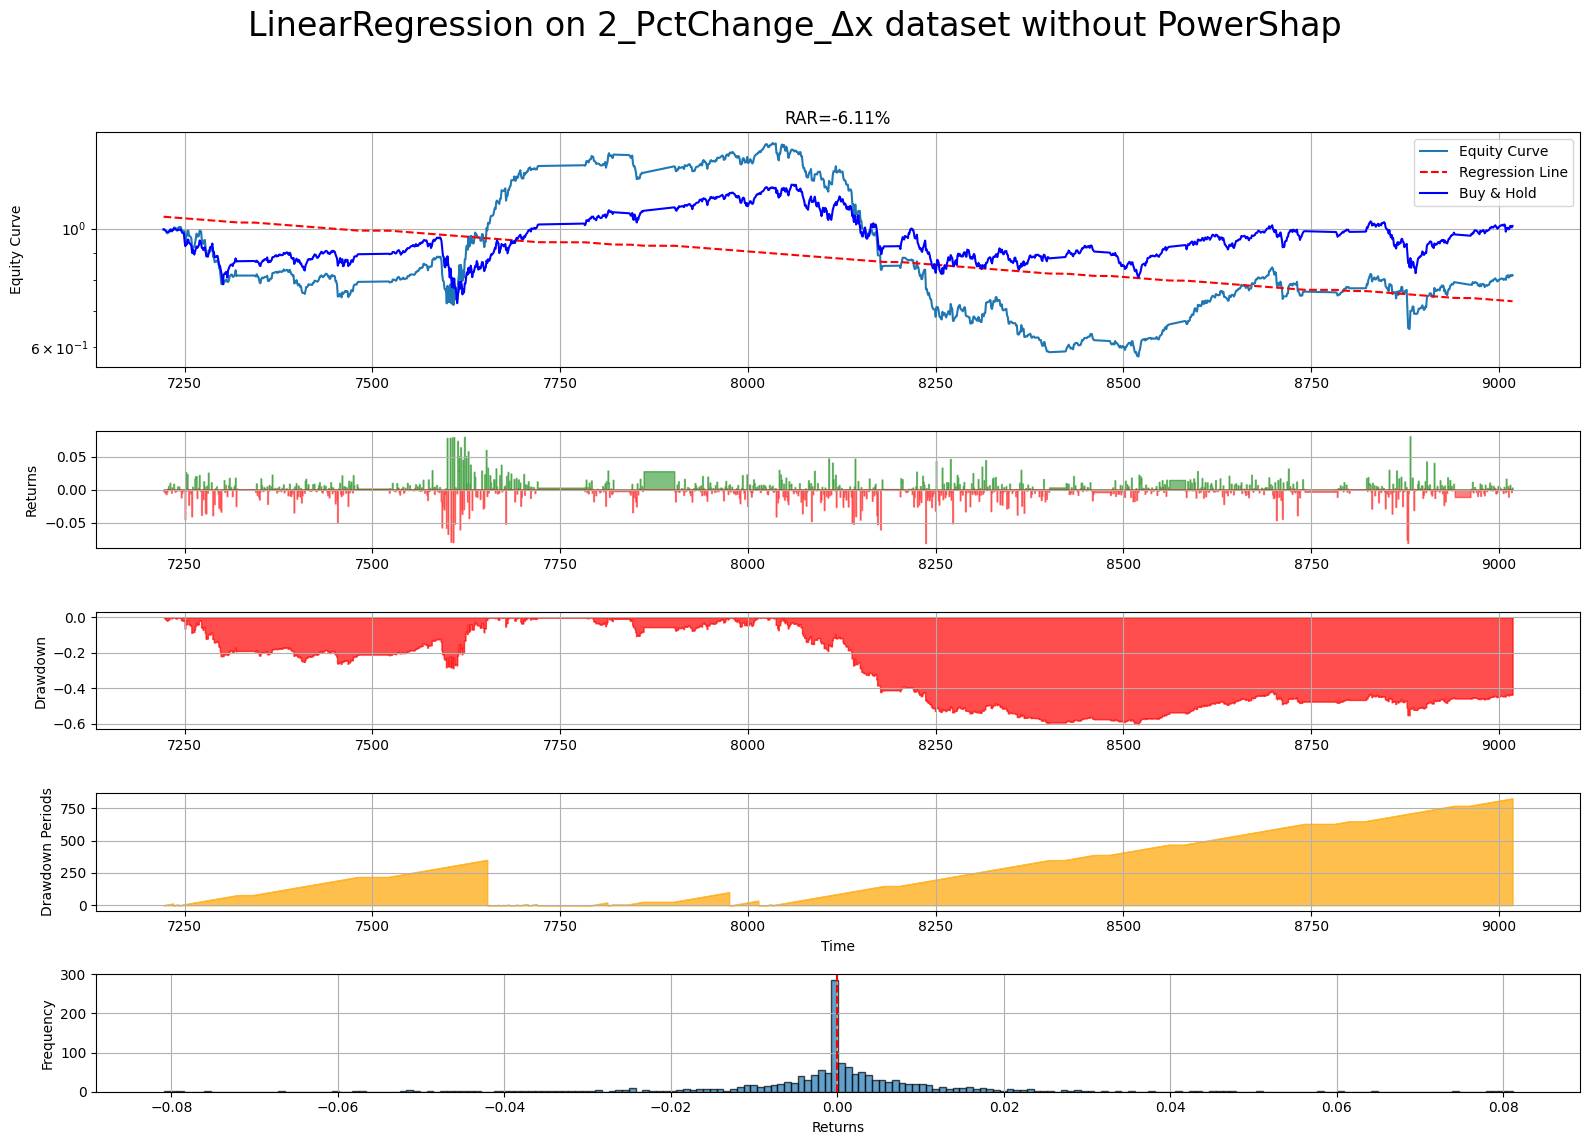

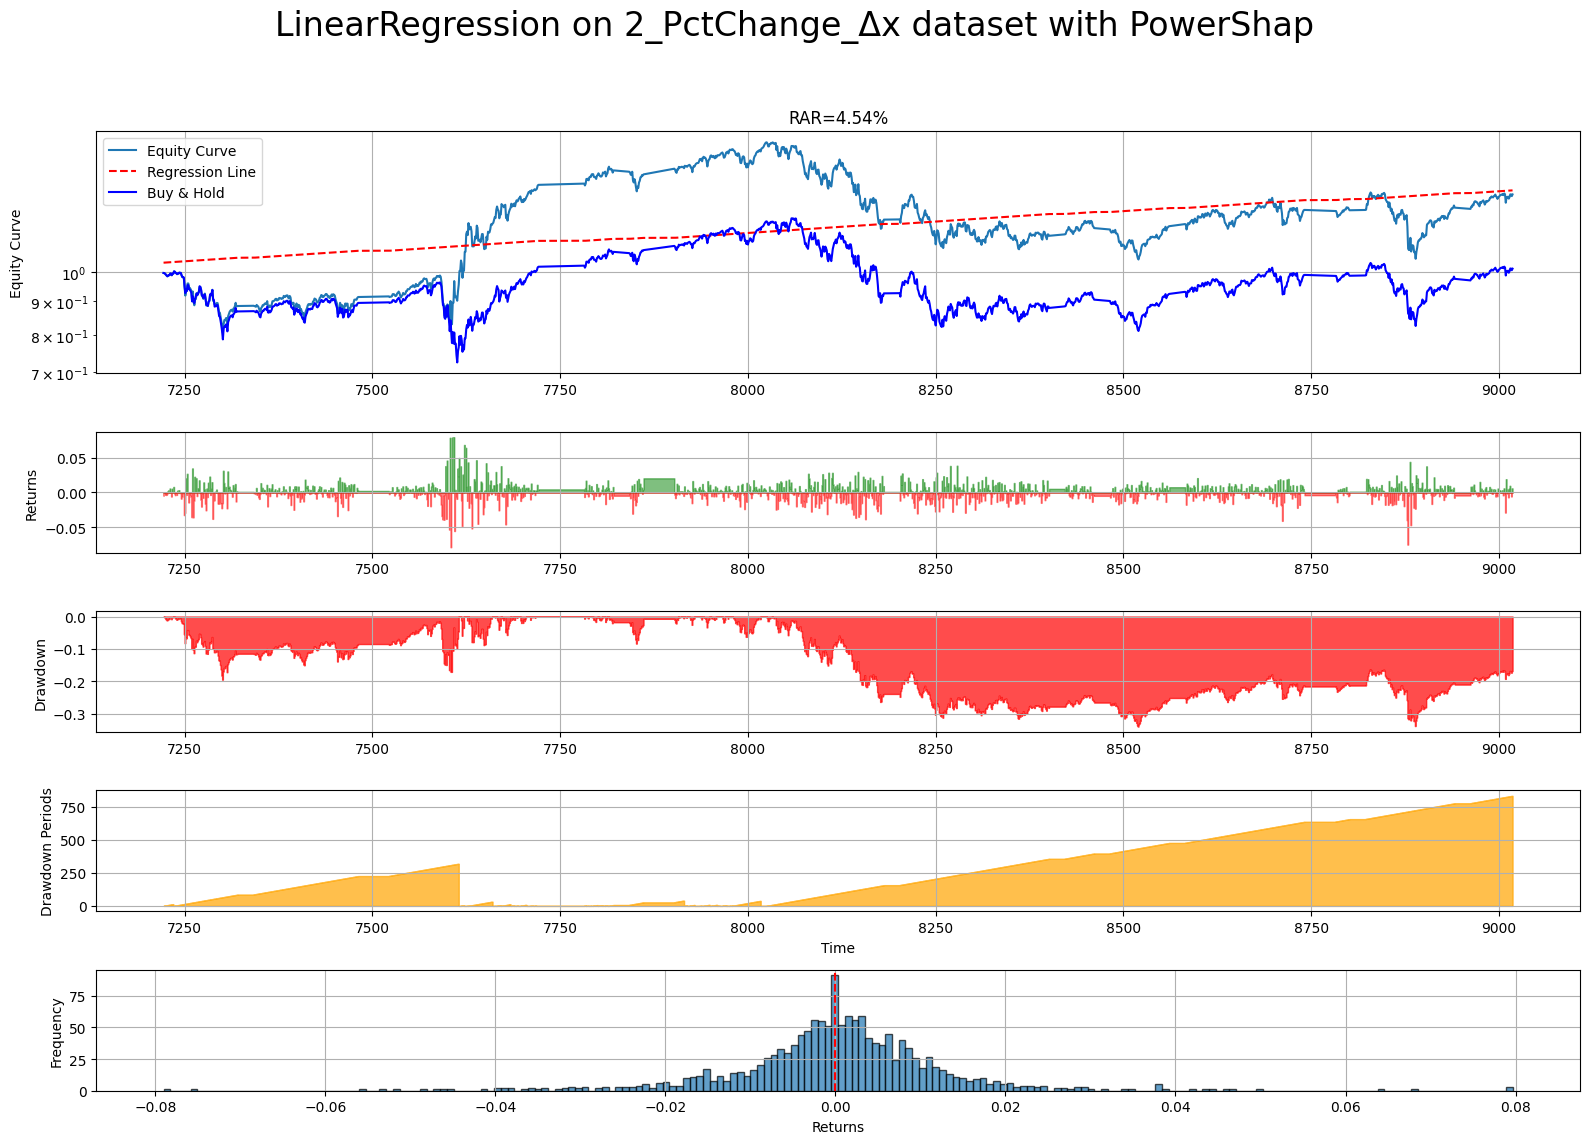

XGBRegressor RMSE: 0.011564
XGBRegressor with PowerShap RMSE: 0.012118
---


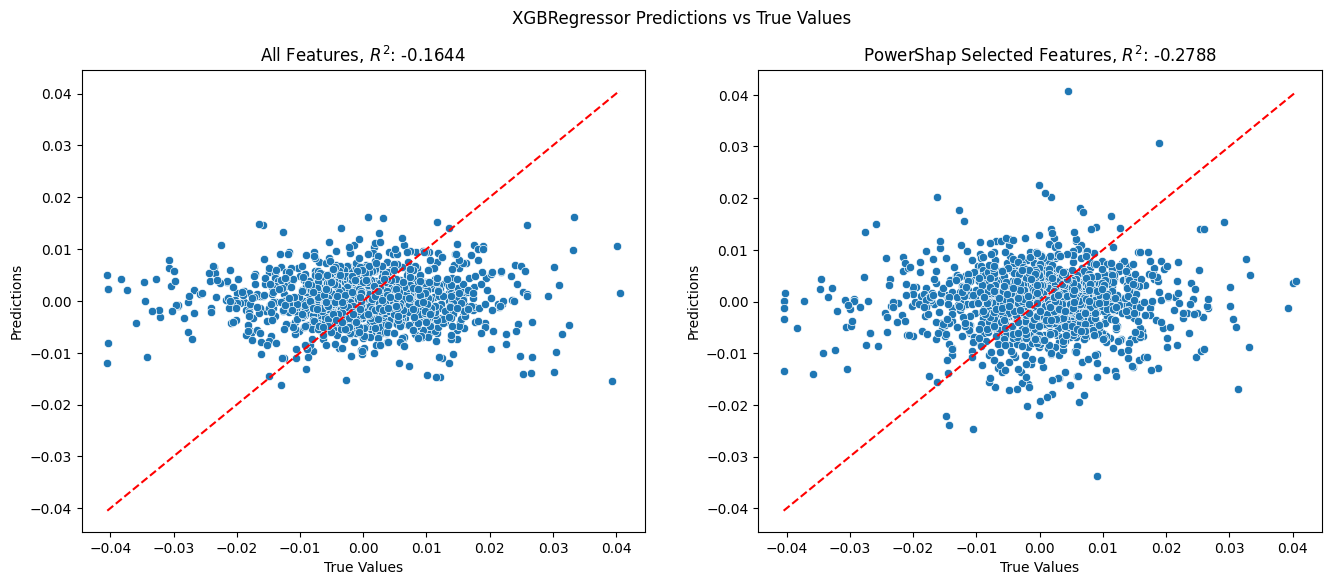

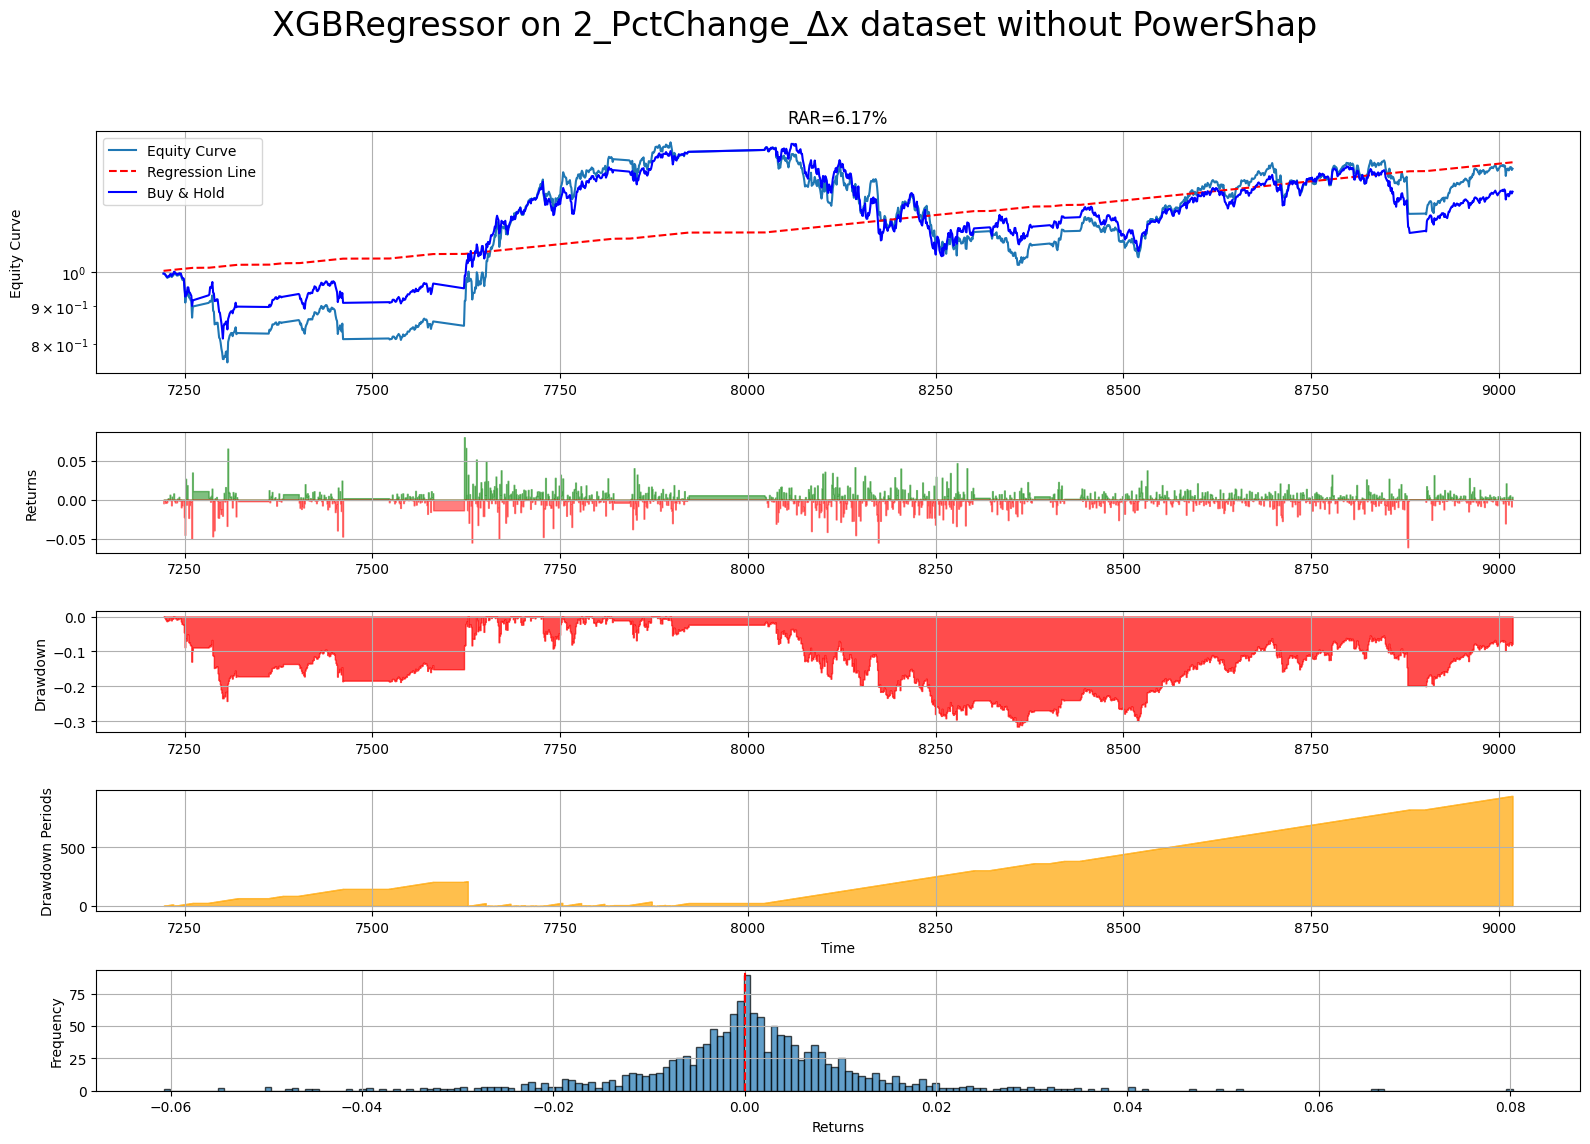

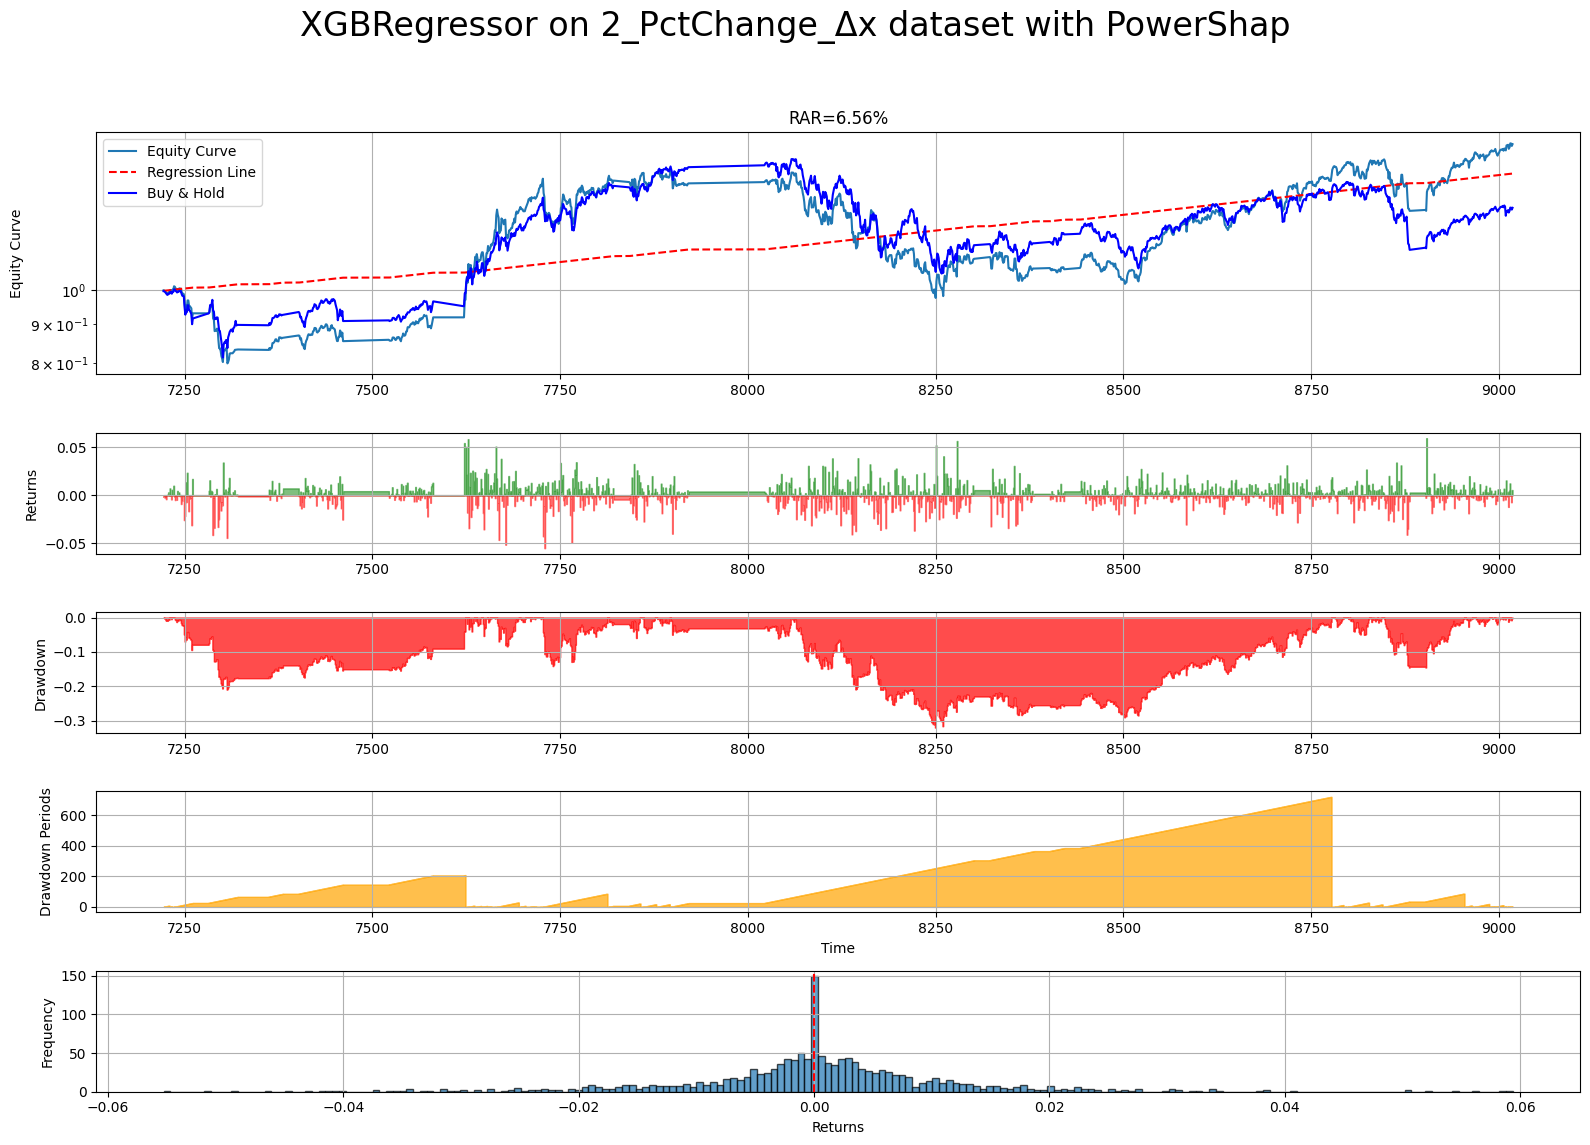

LinearRegression RMSE: 0.013497
LinearRegression with PowerShap RMSE: 0.011716
---


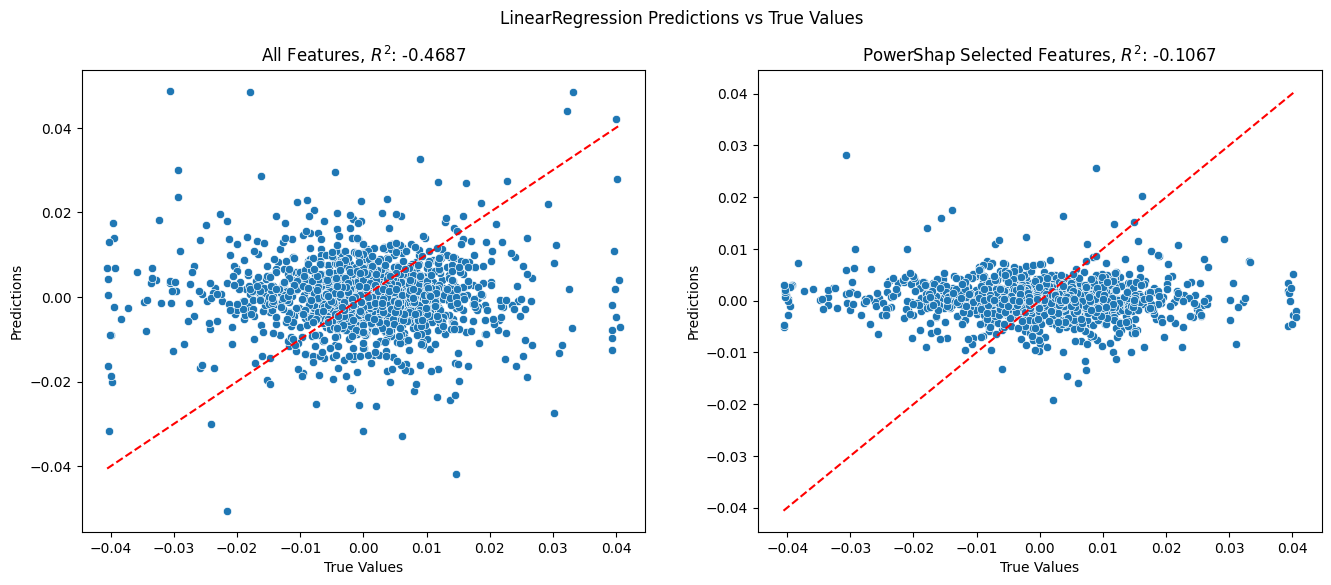

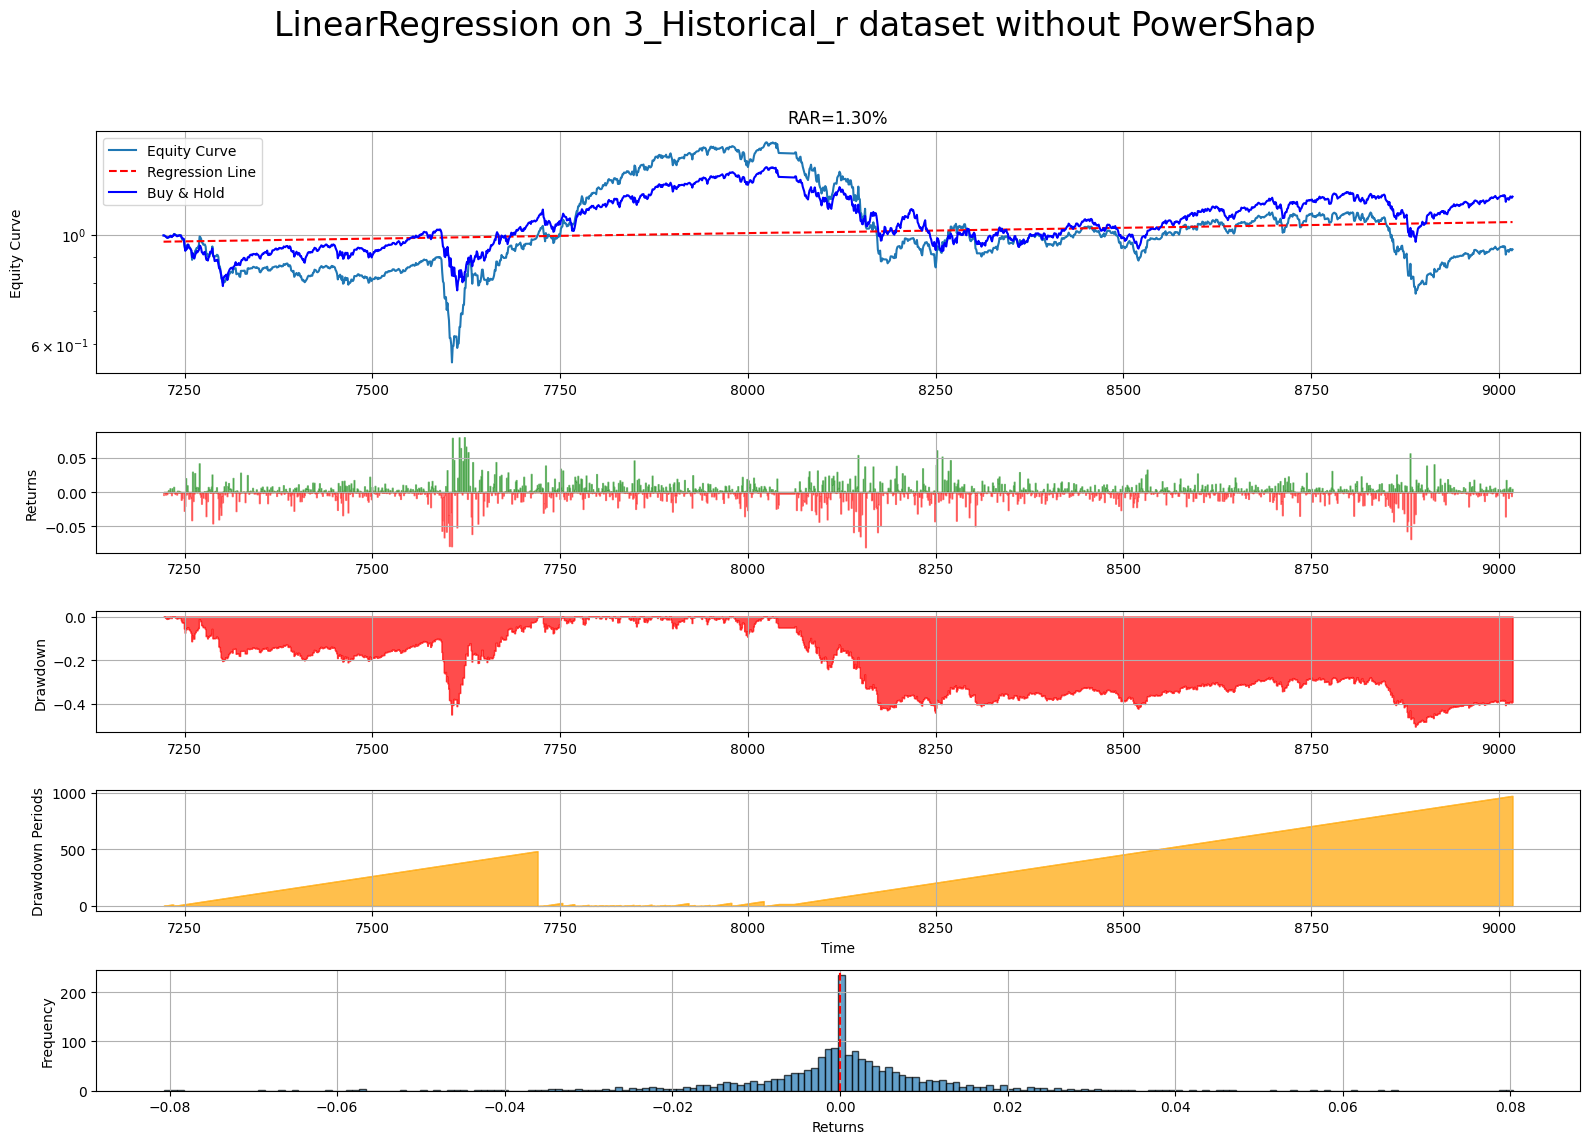

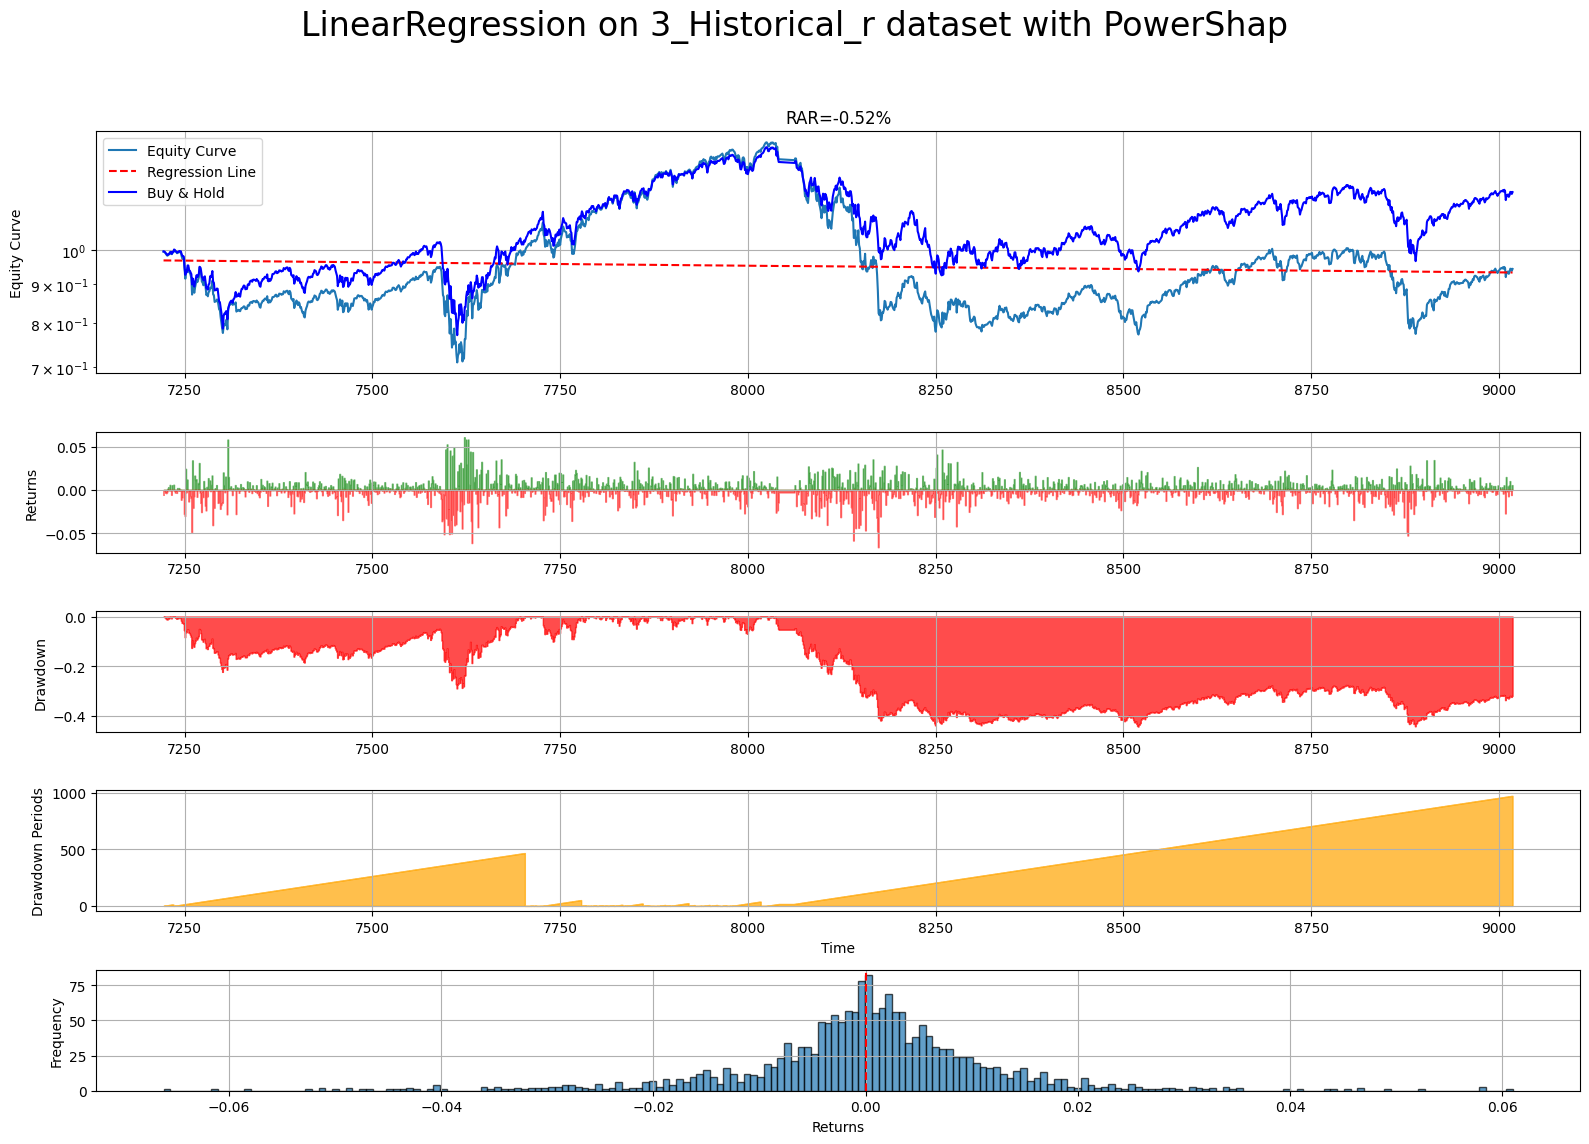

XGBRegressor RMSE: 0.012544
XGBRegressor with PowerShap RMSE: 0.013496
---


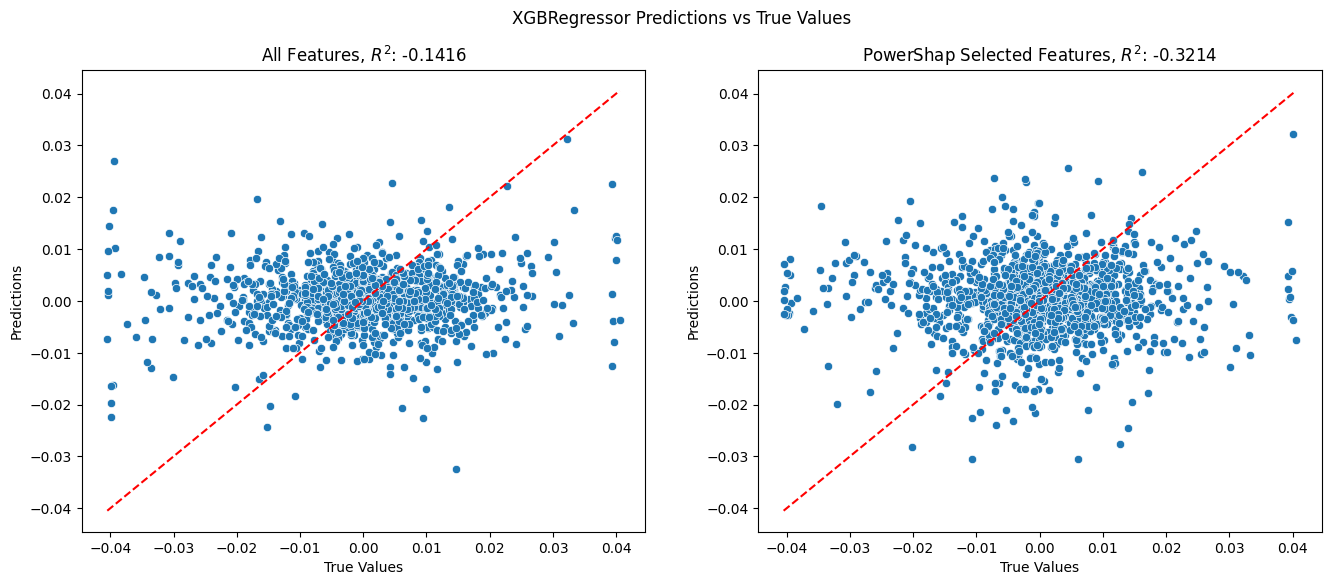

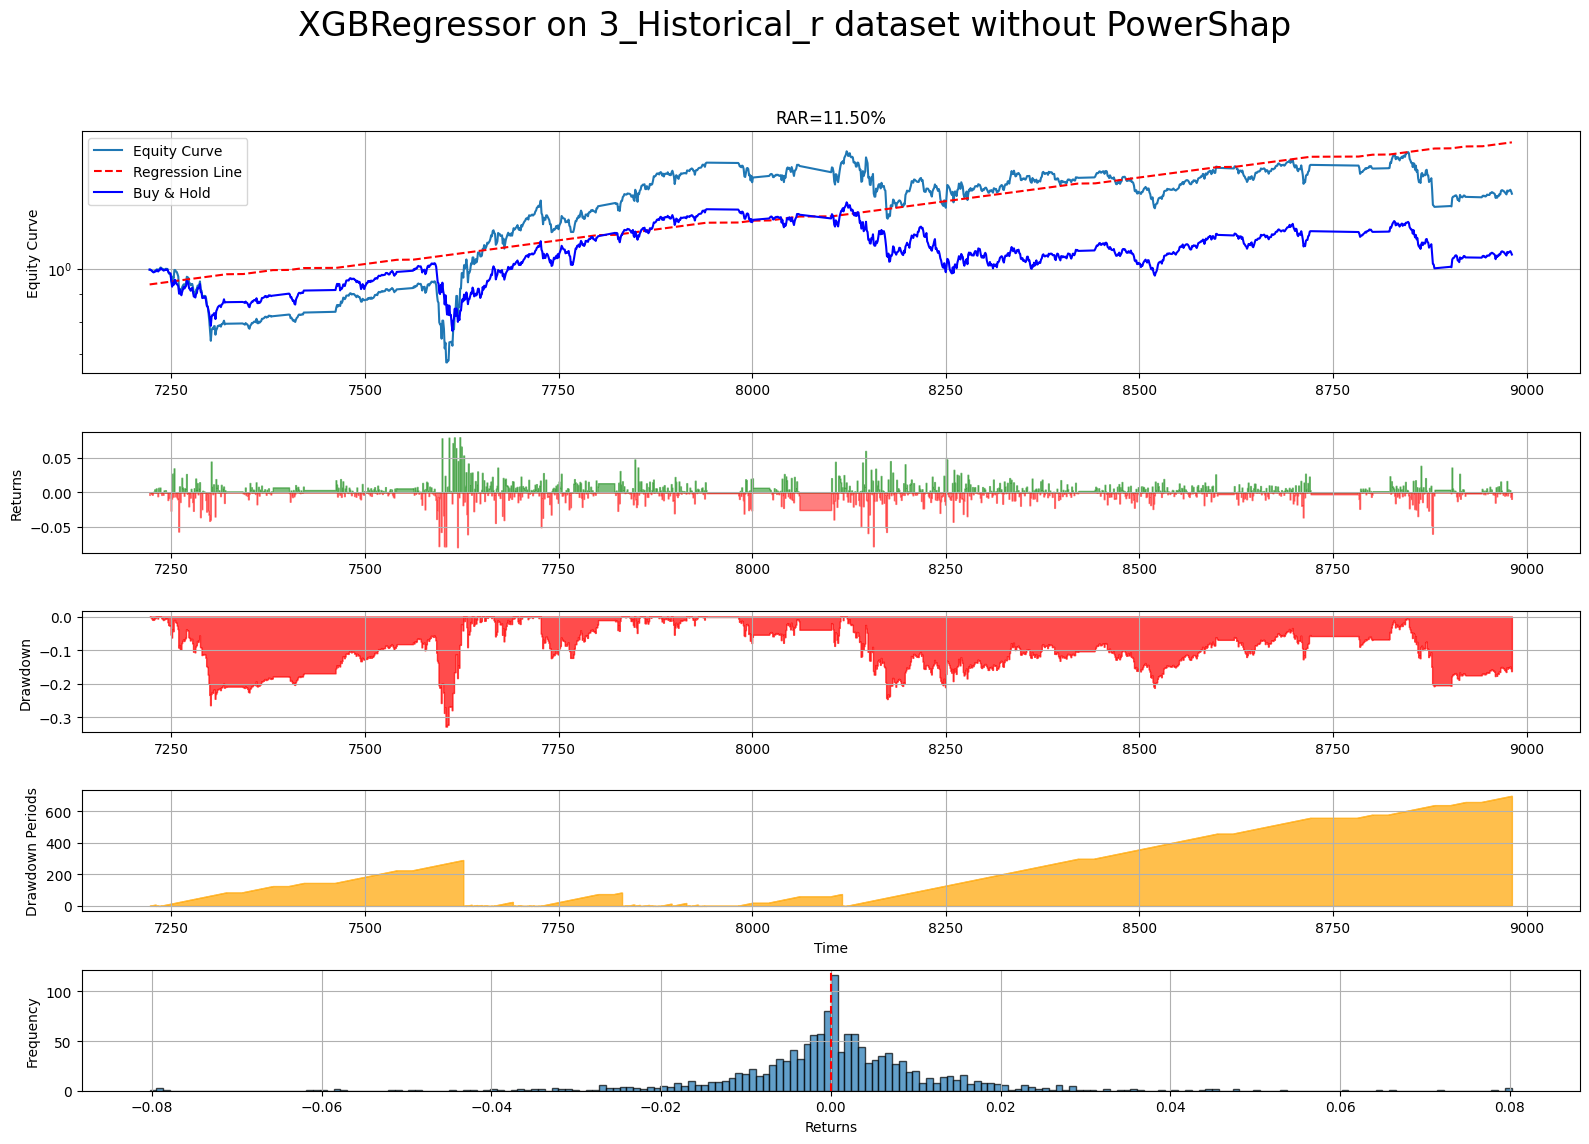

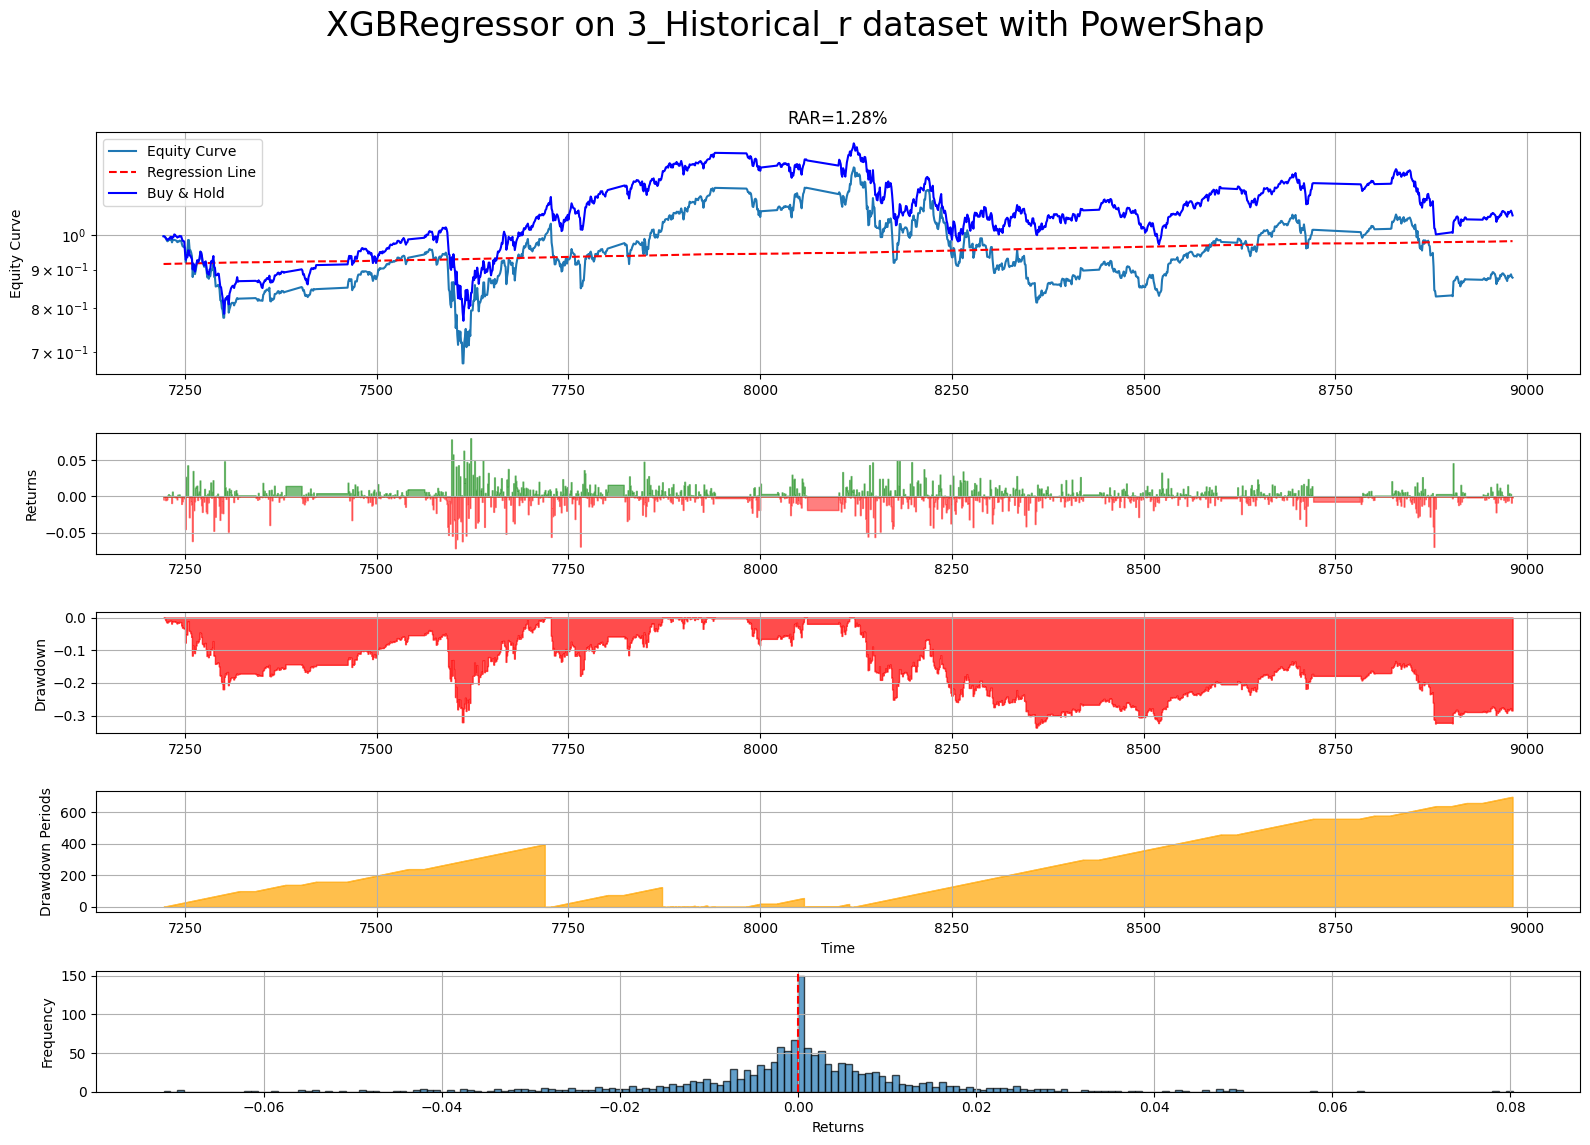

LinearRegression RMSE: 0.026970
LinearRegression with PowerShap RMSE: 0.014763
---


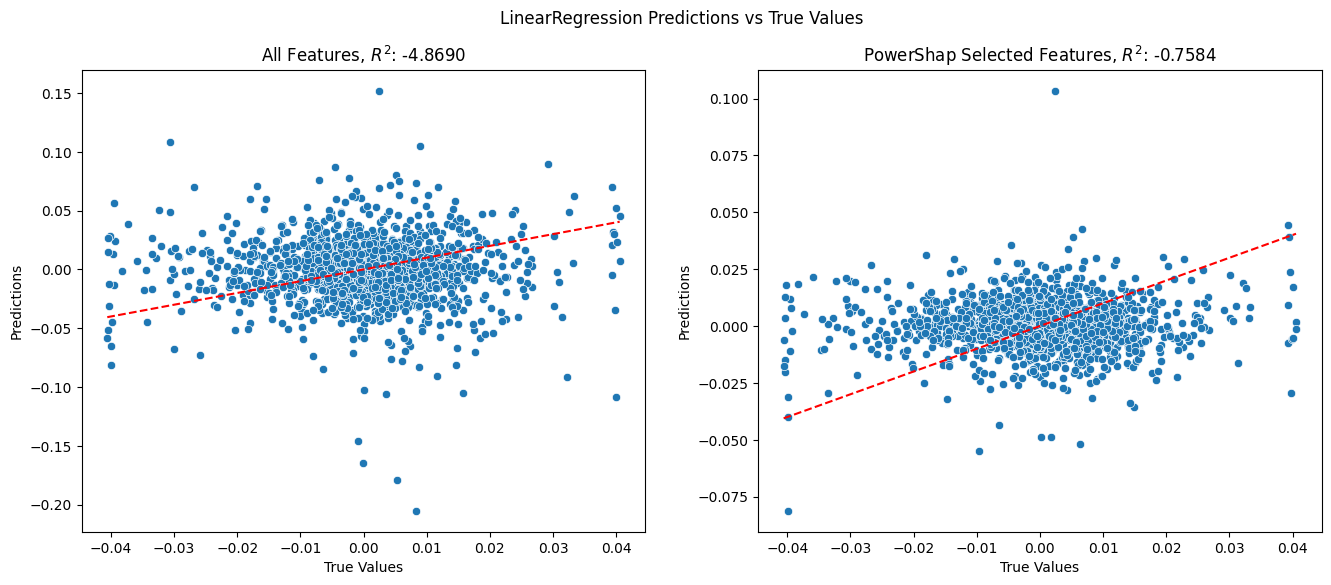

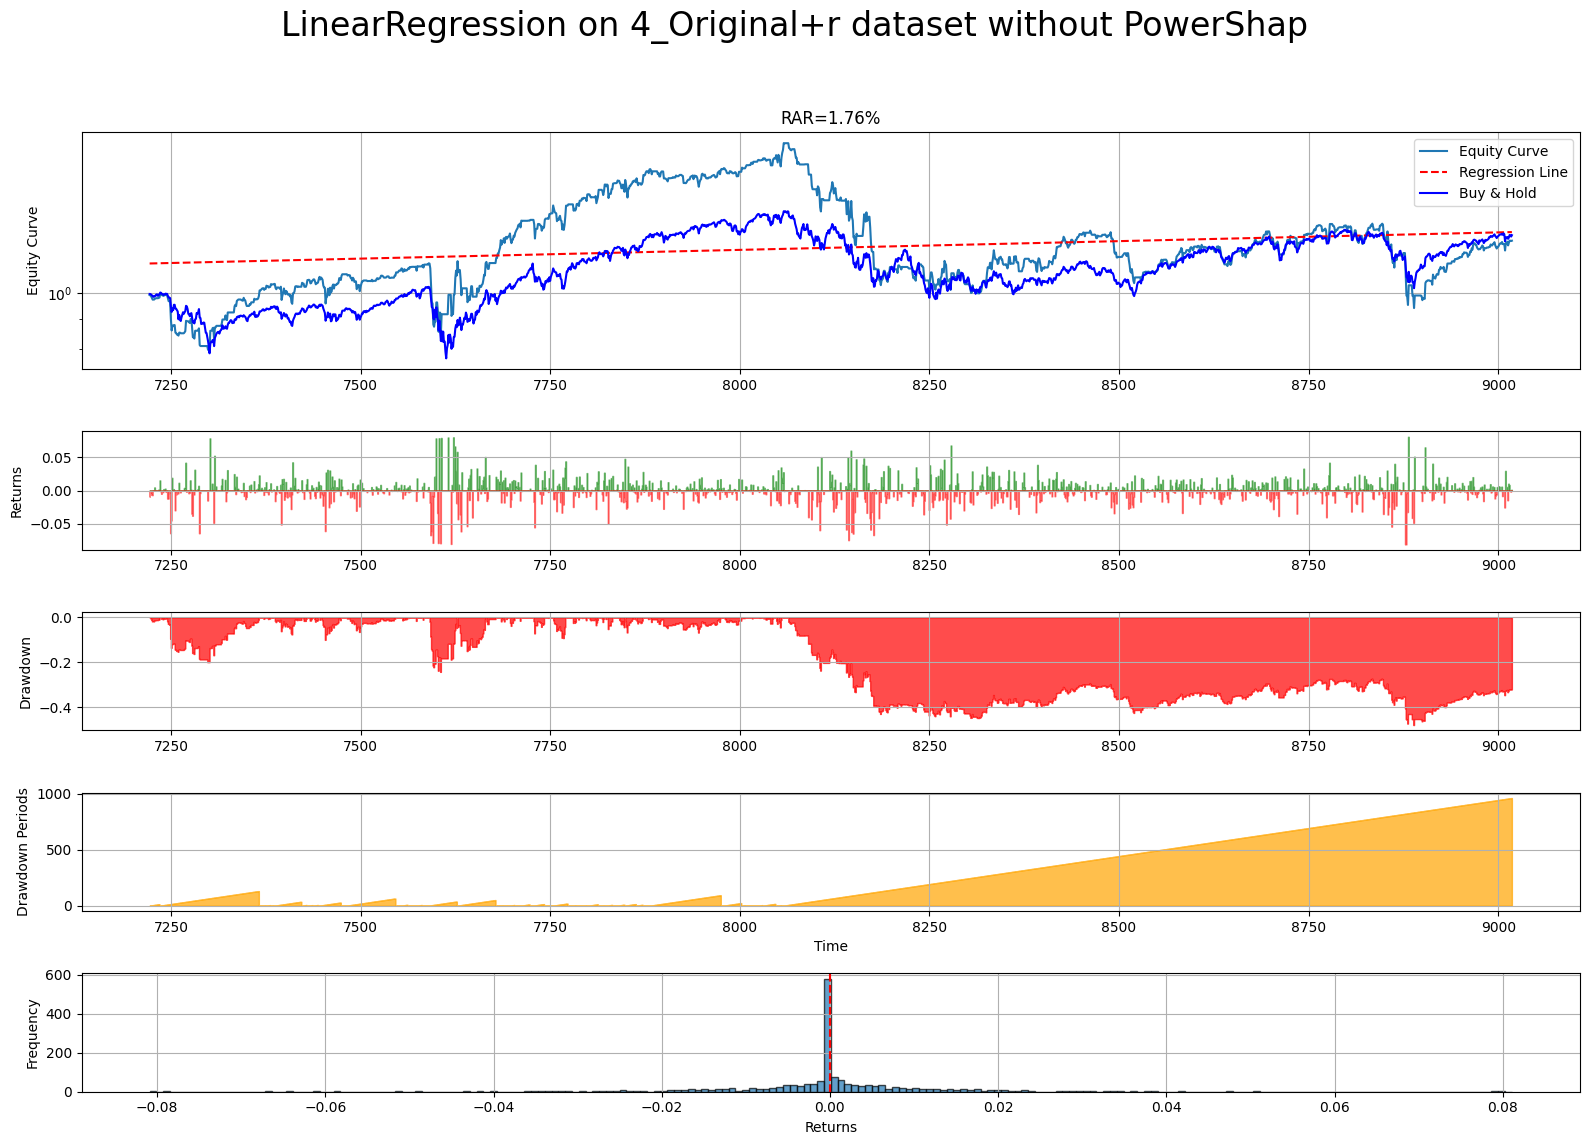

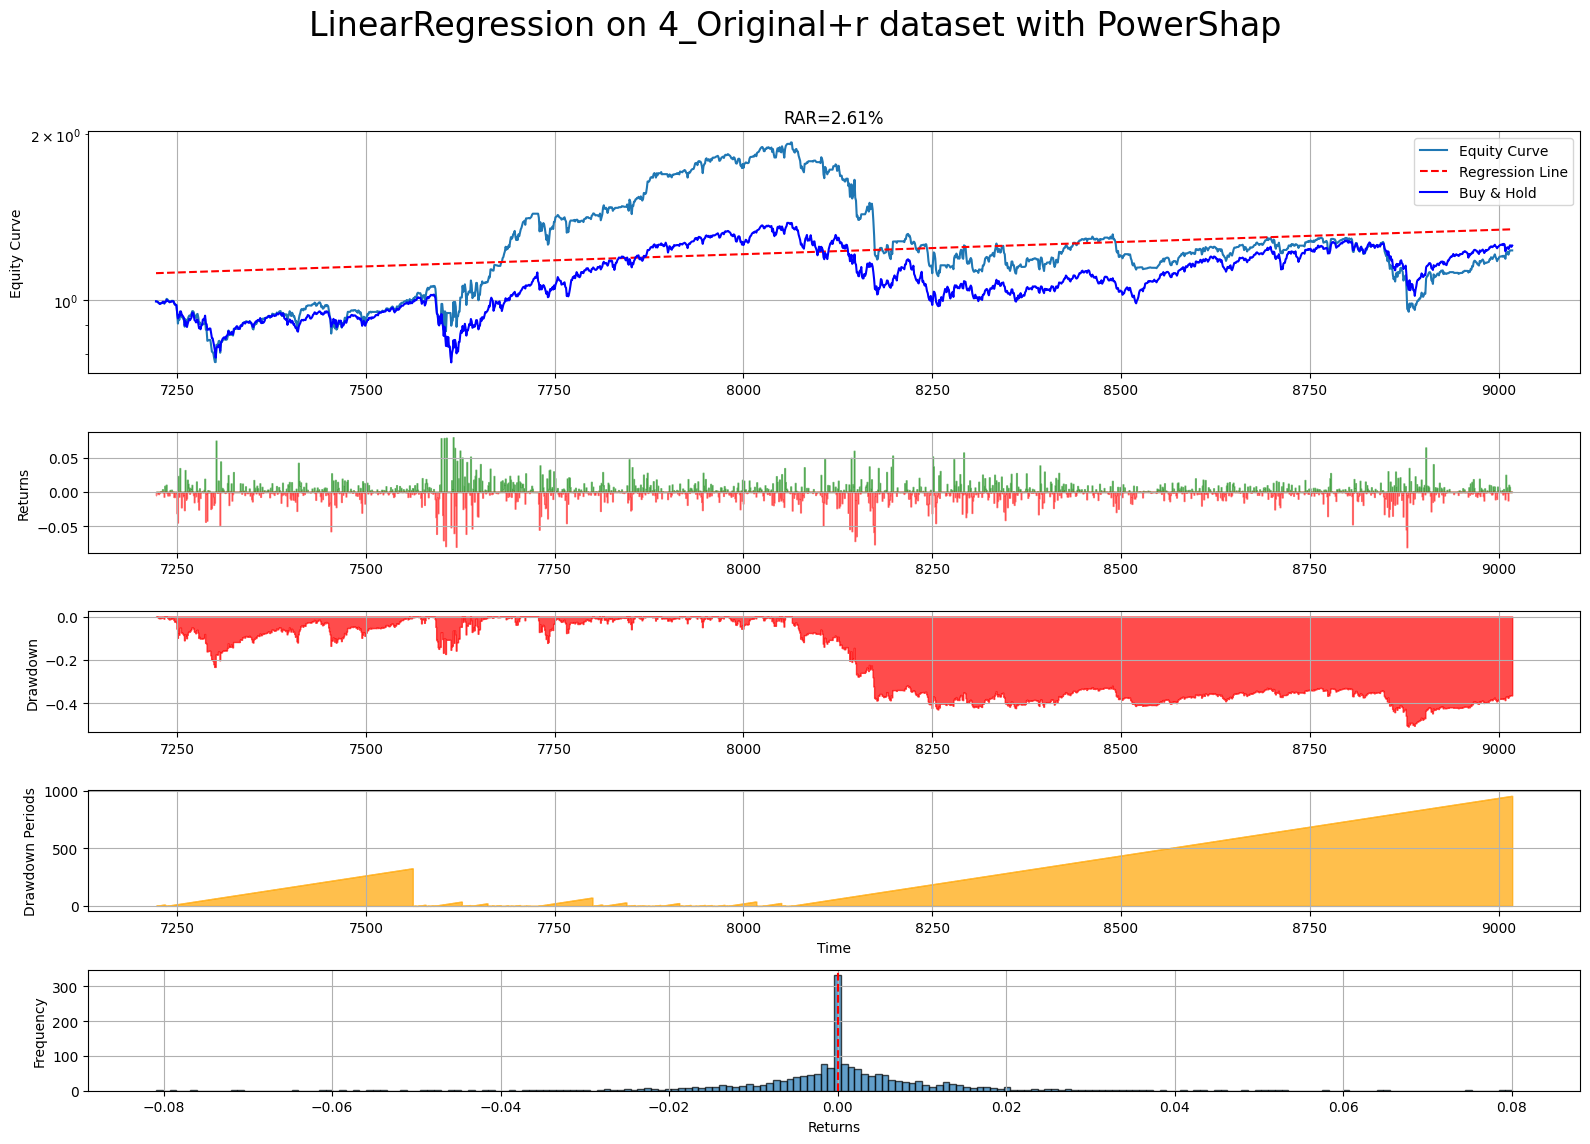

XGBRegressor RMSE: 0.012091
XGBRegressor with PowerShap RMSE: 0.012982
---


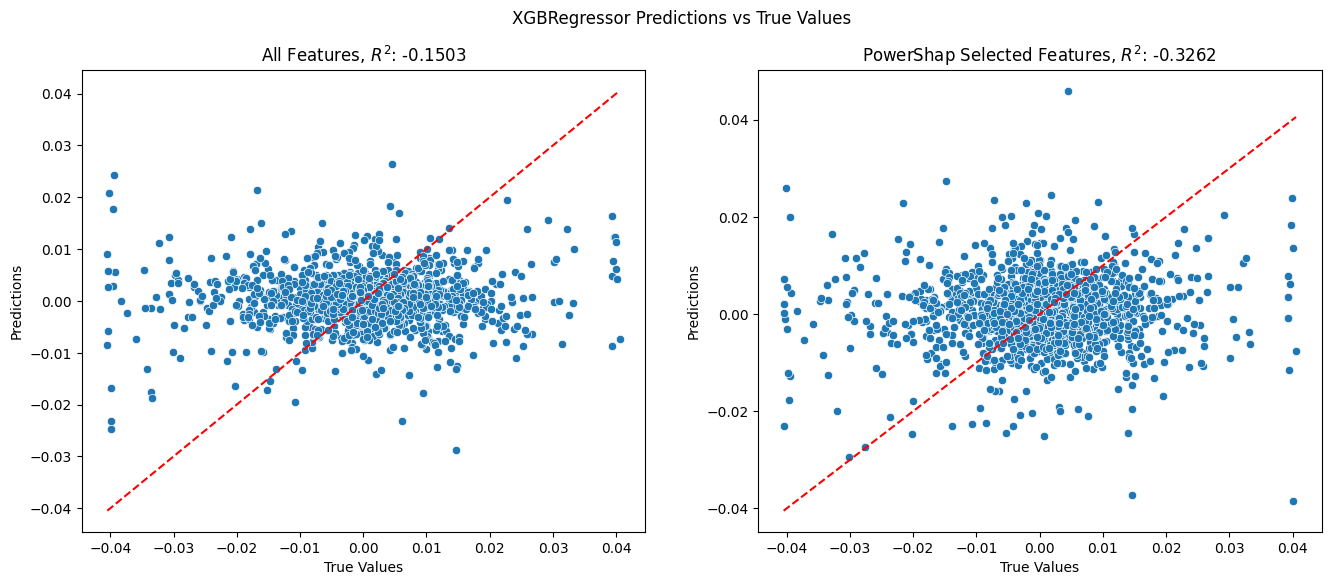

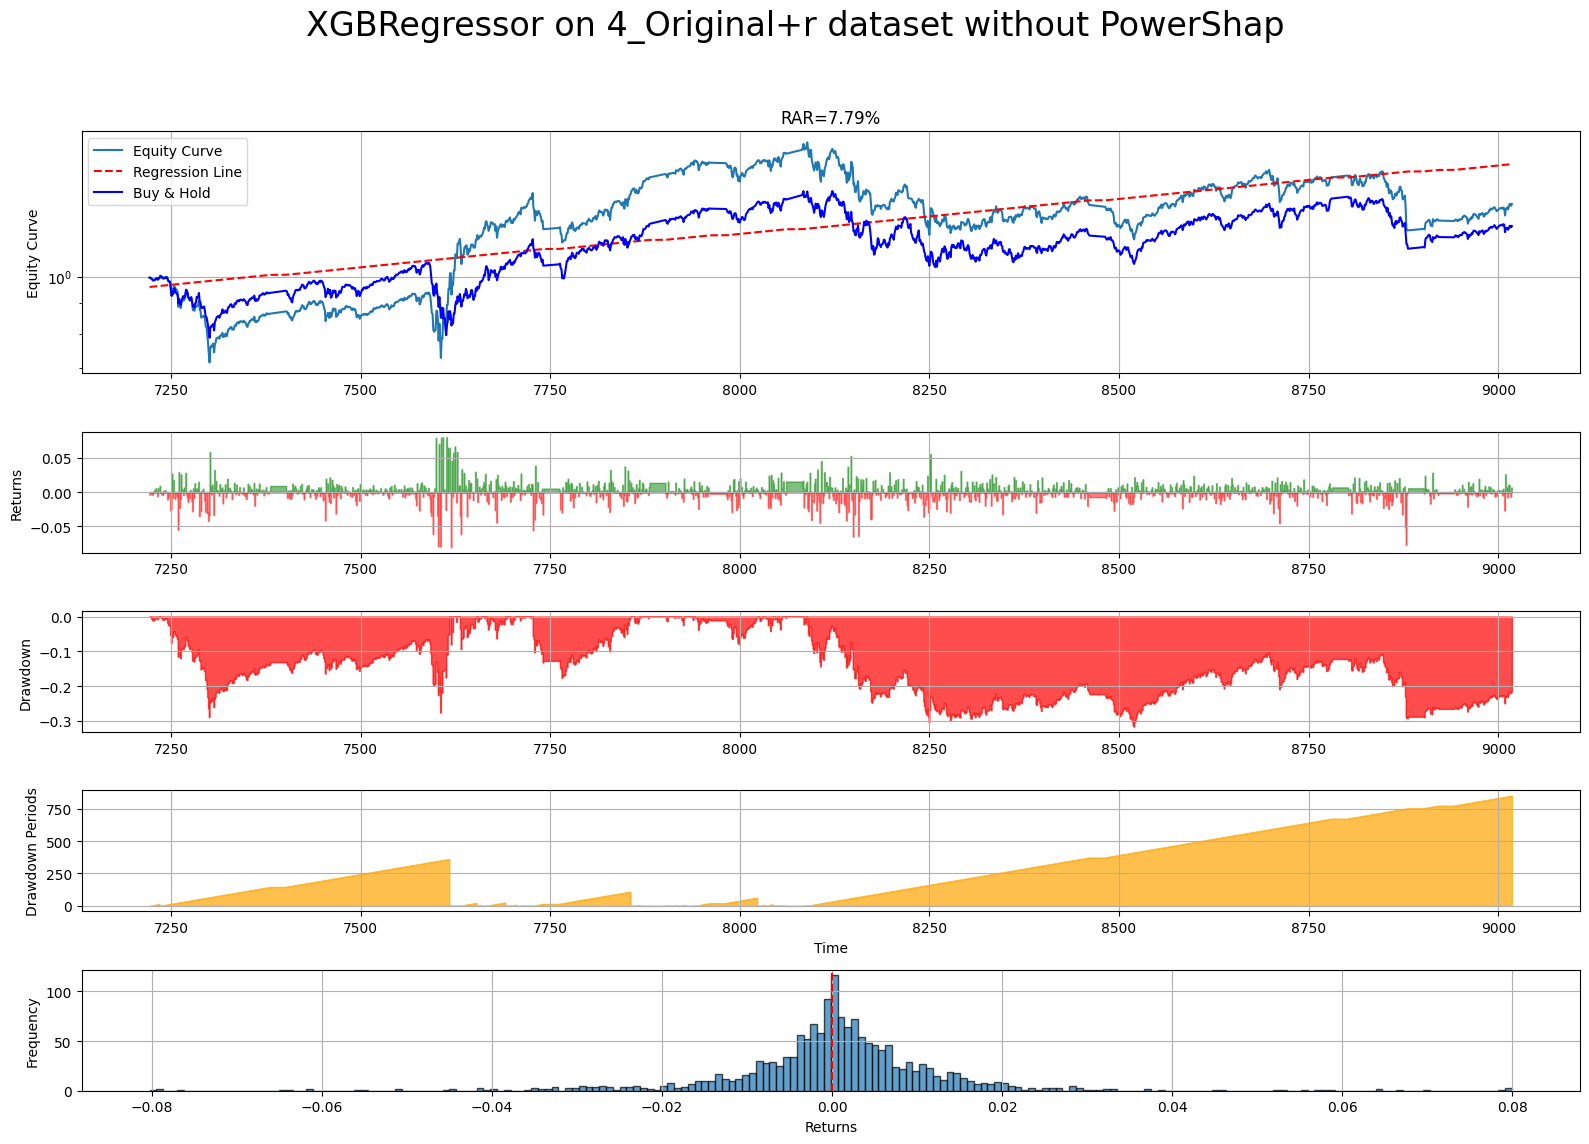

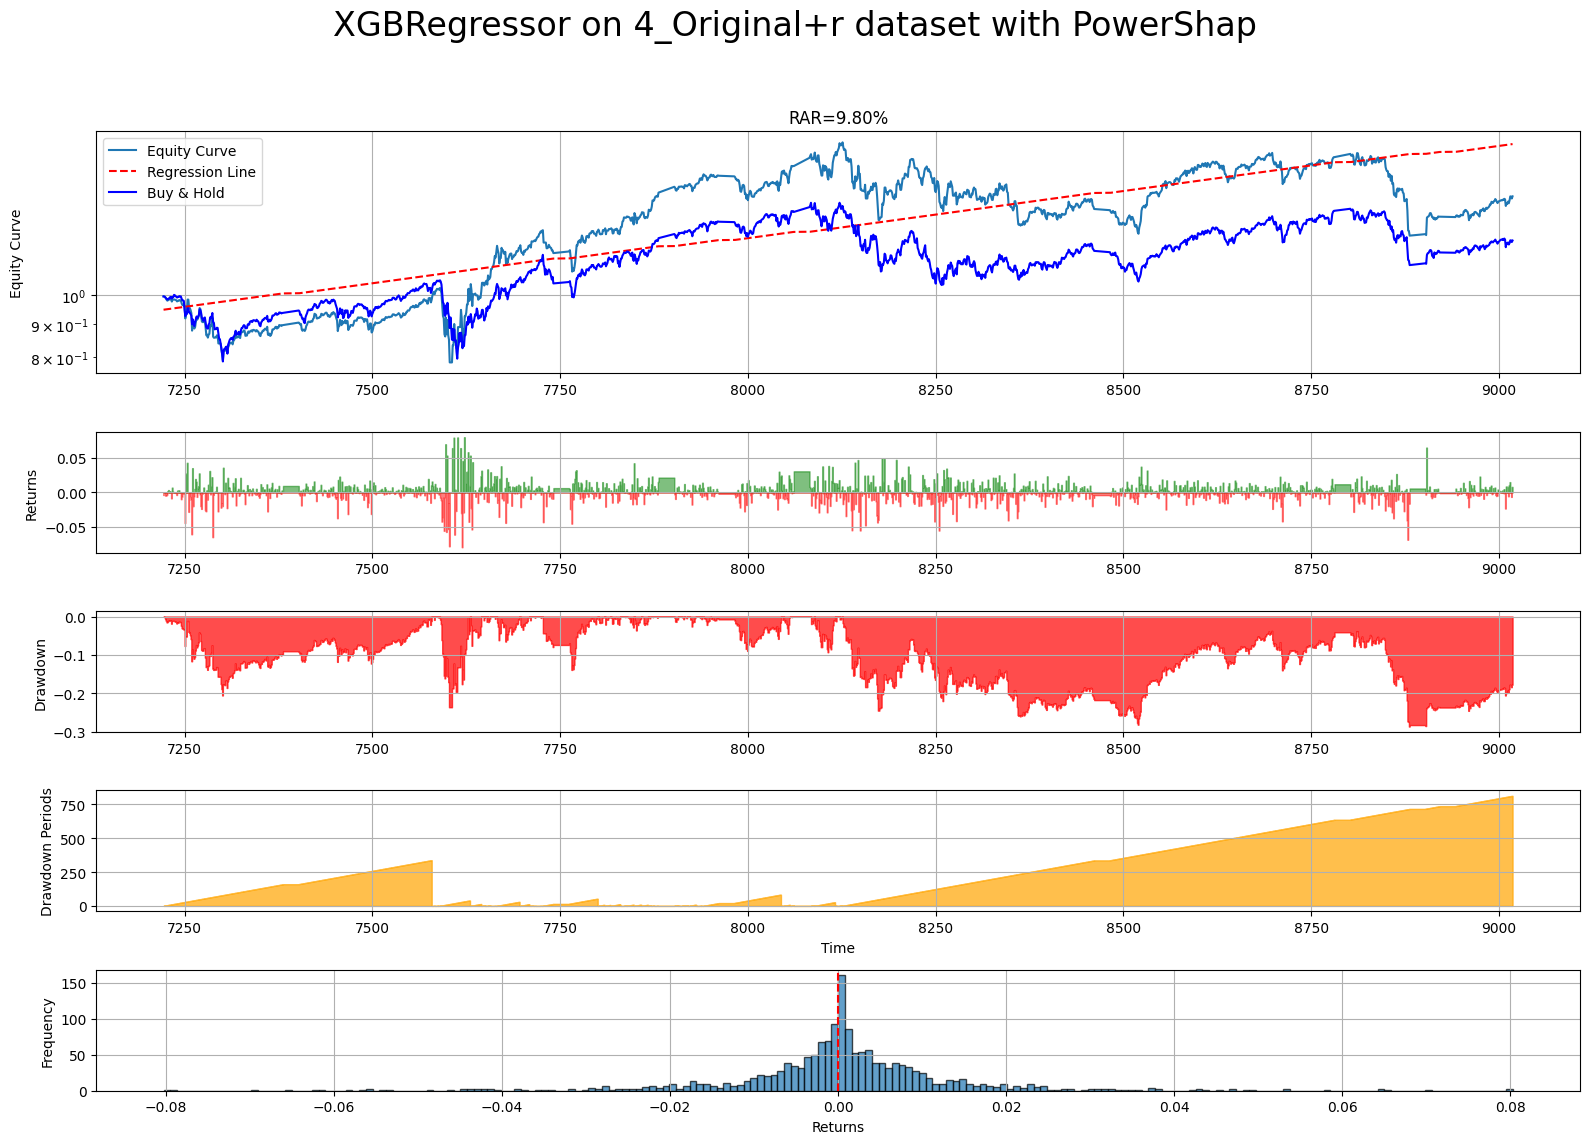

LinearRegression RMSE: 0.273136
LinearRegression with PowerShap RMSE: 0.040431
---


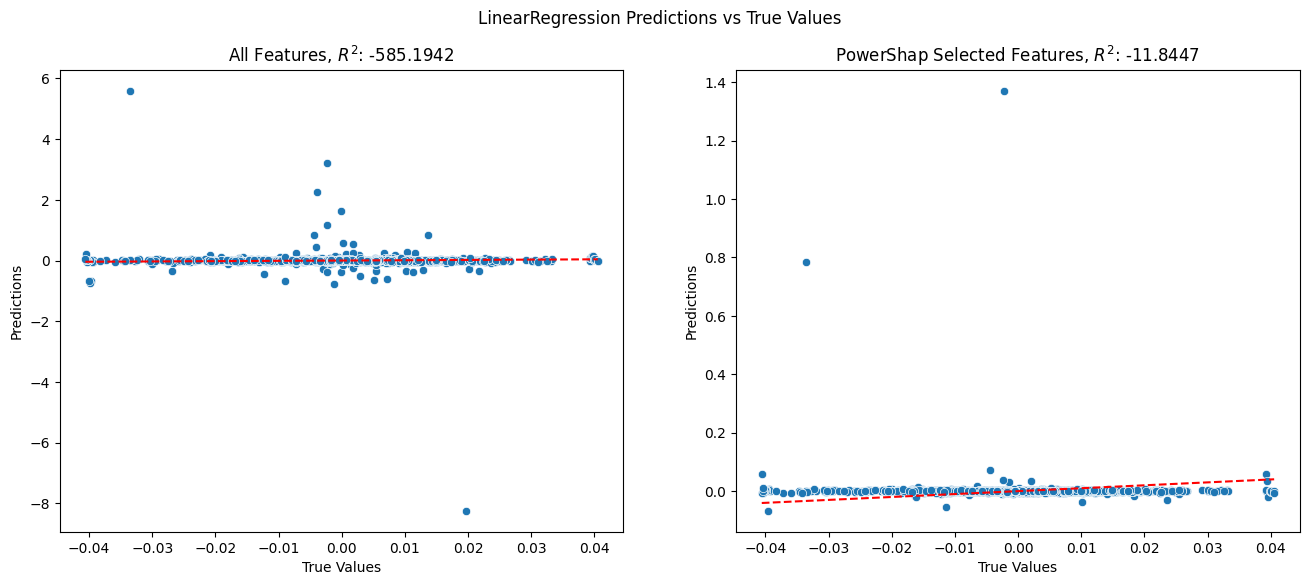

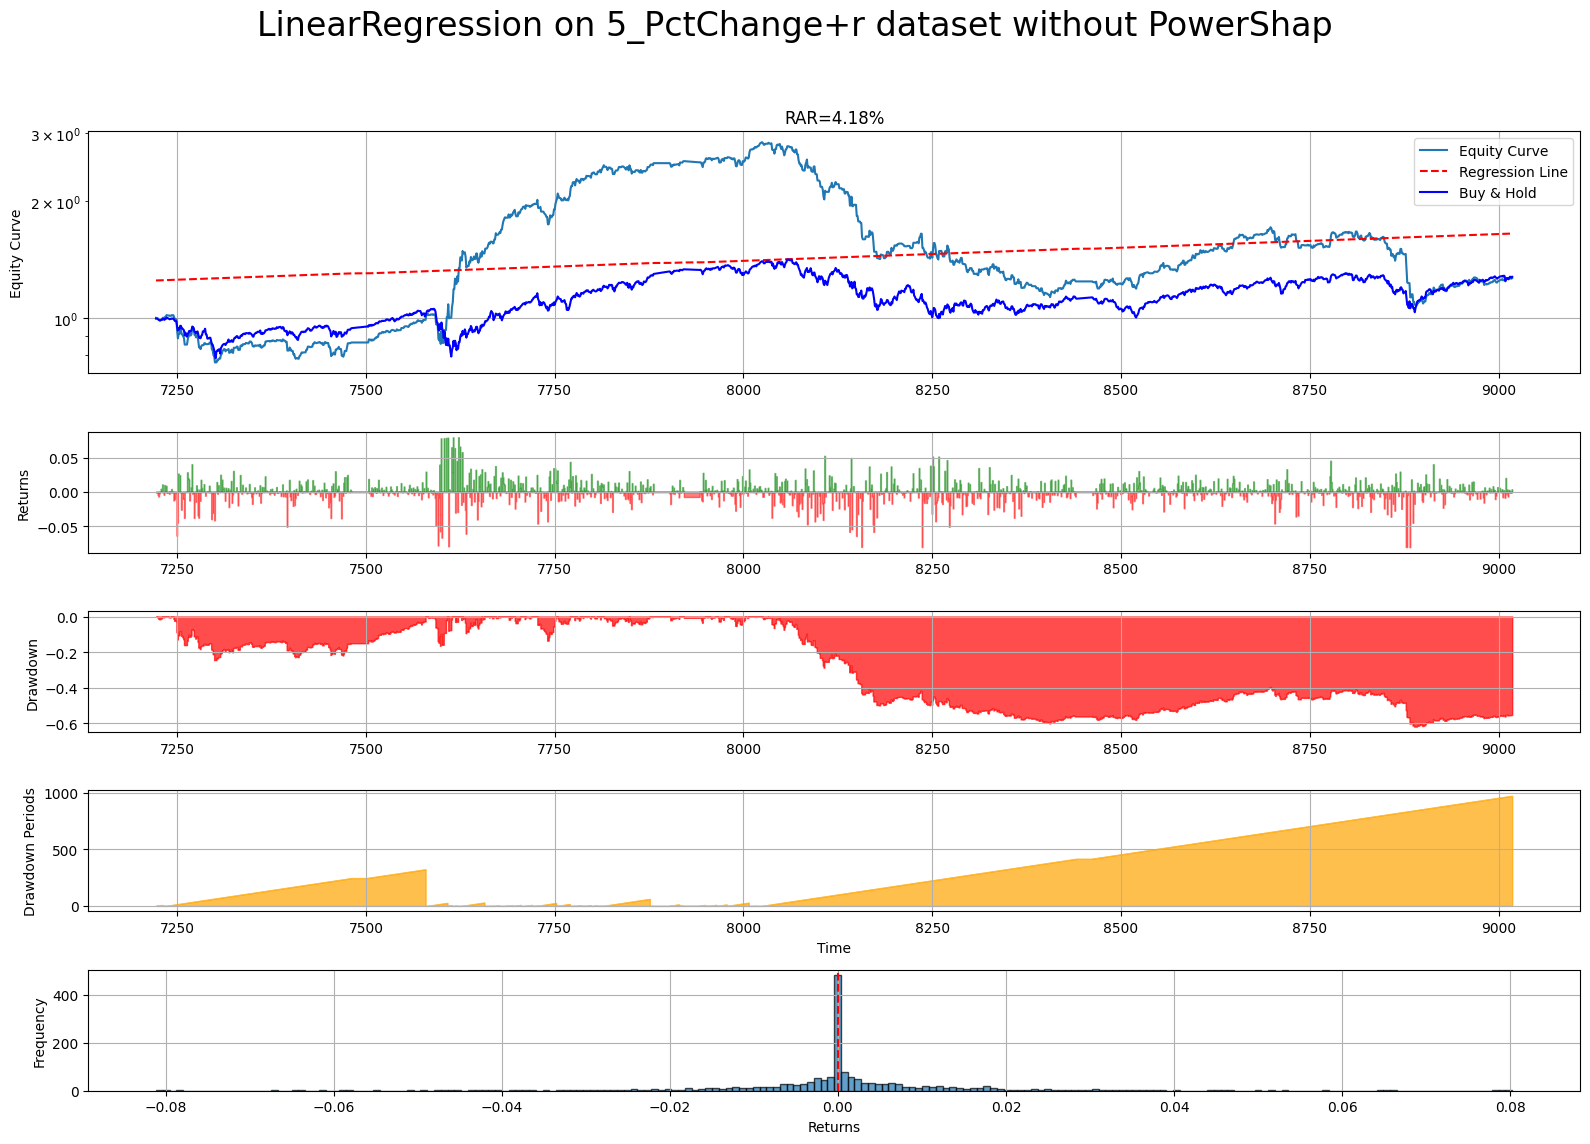

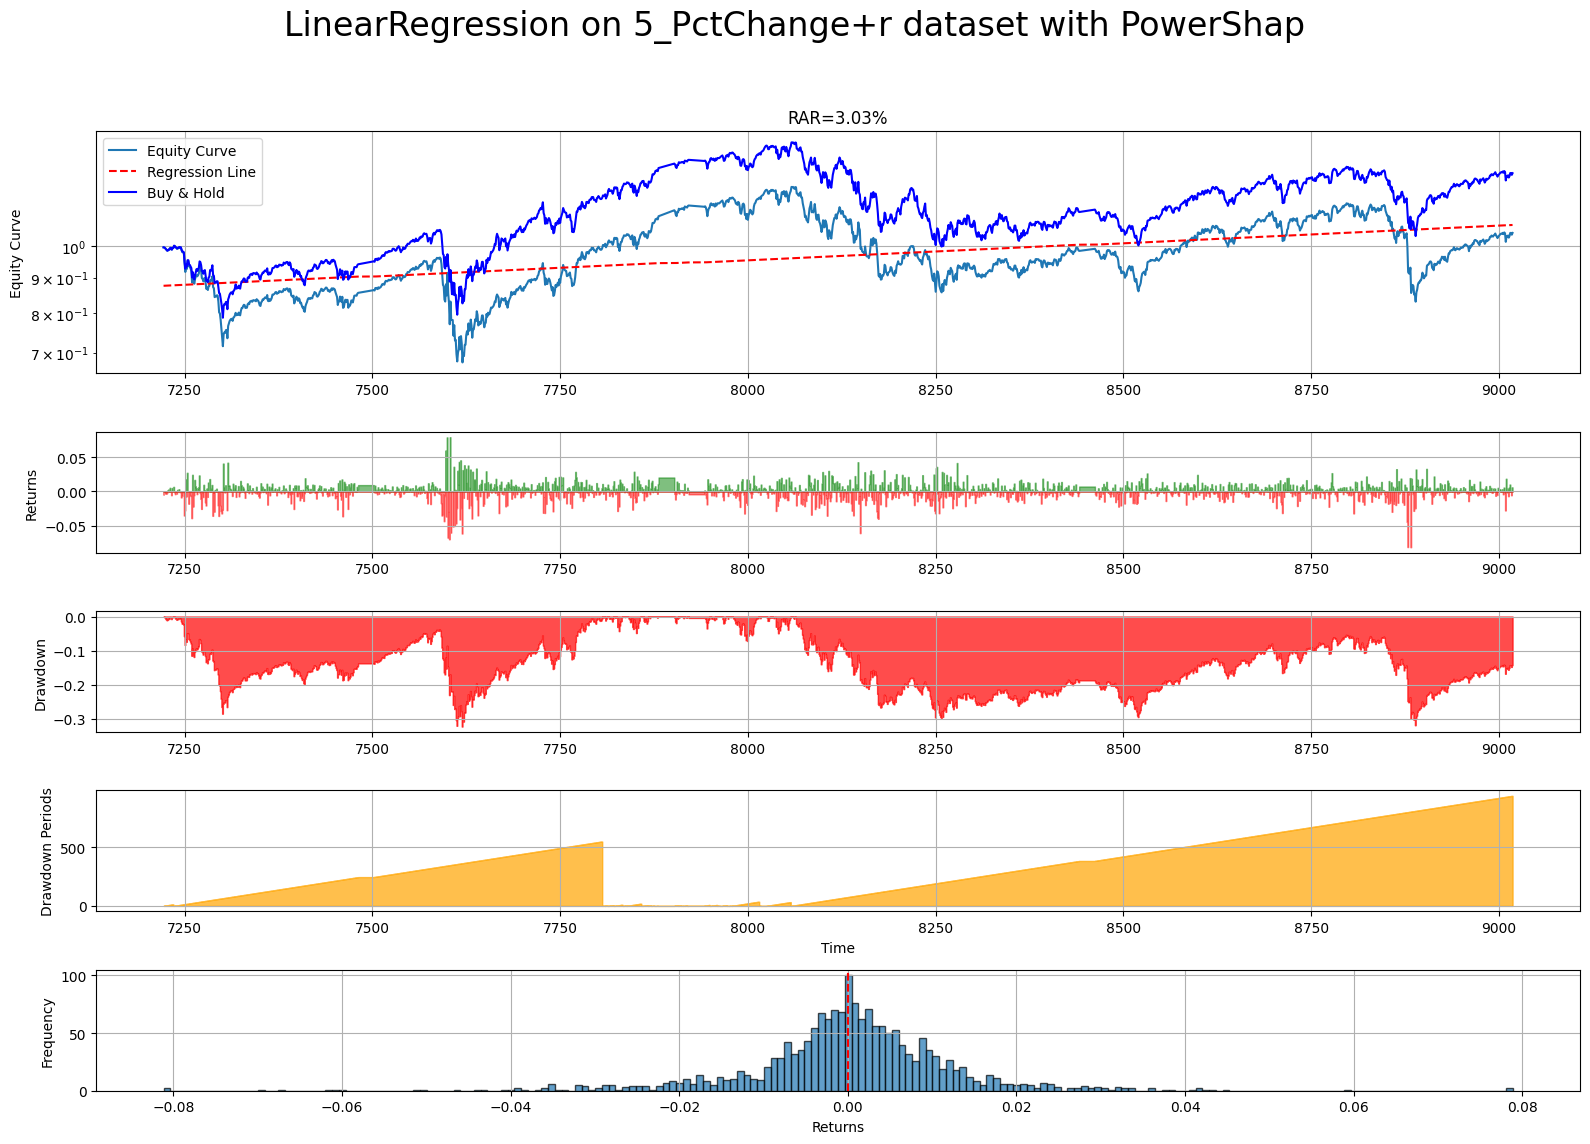

XGBRegressor RMSE: 0.011813
XGBRegressor with PowerShap RMSE: 0.012753
---


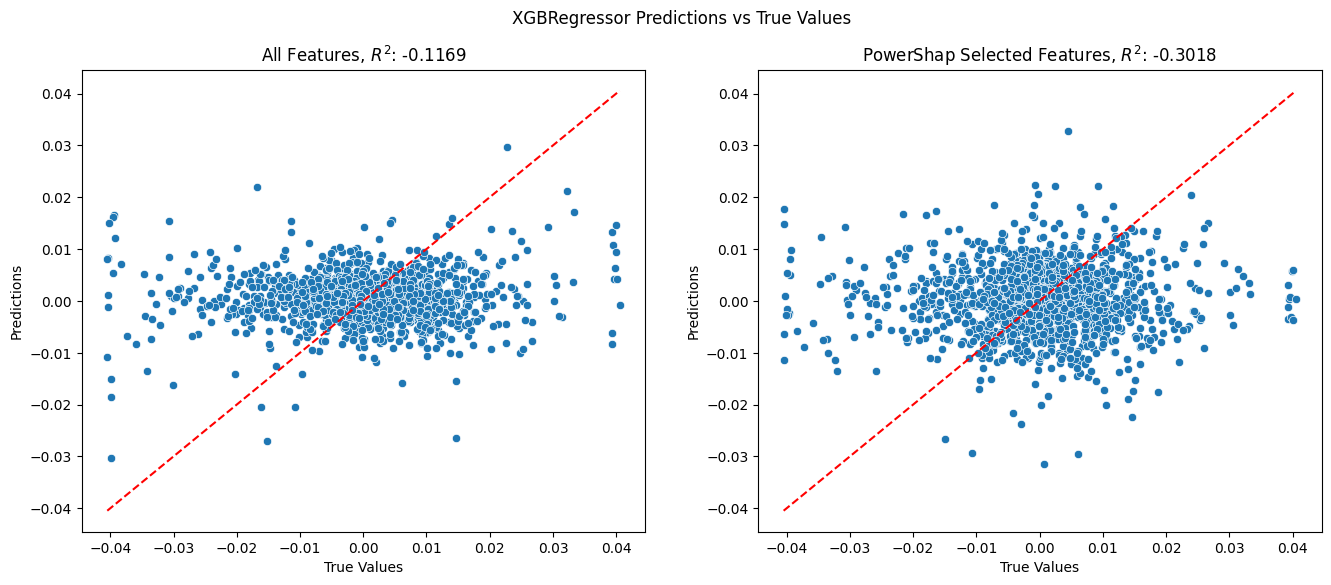

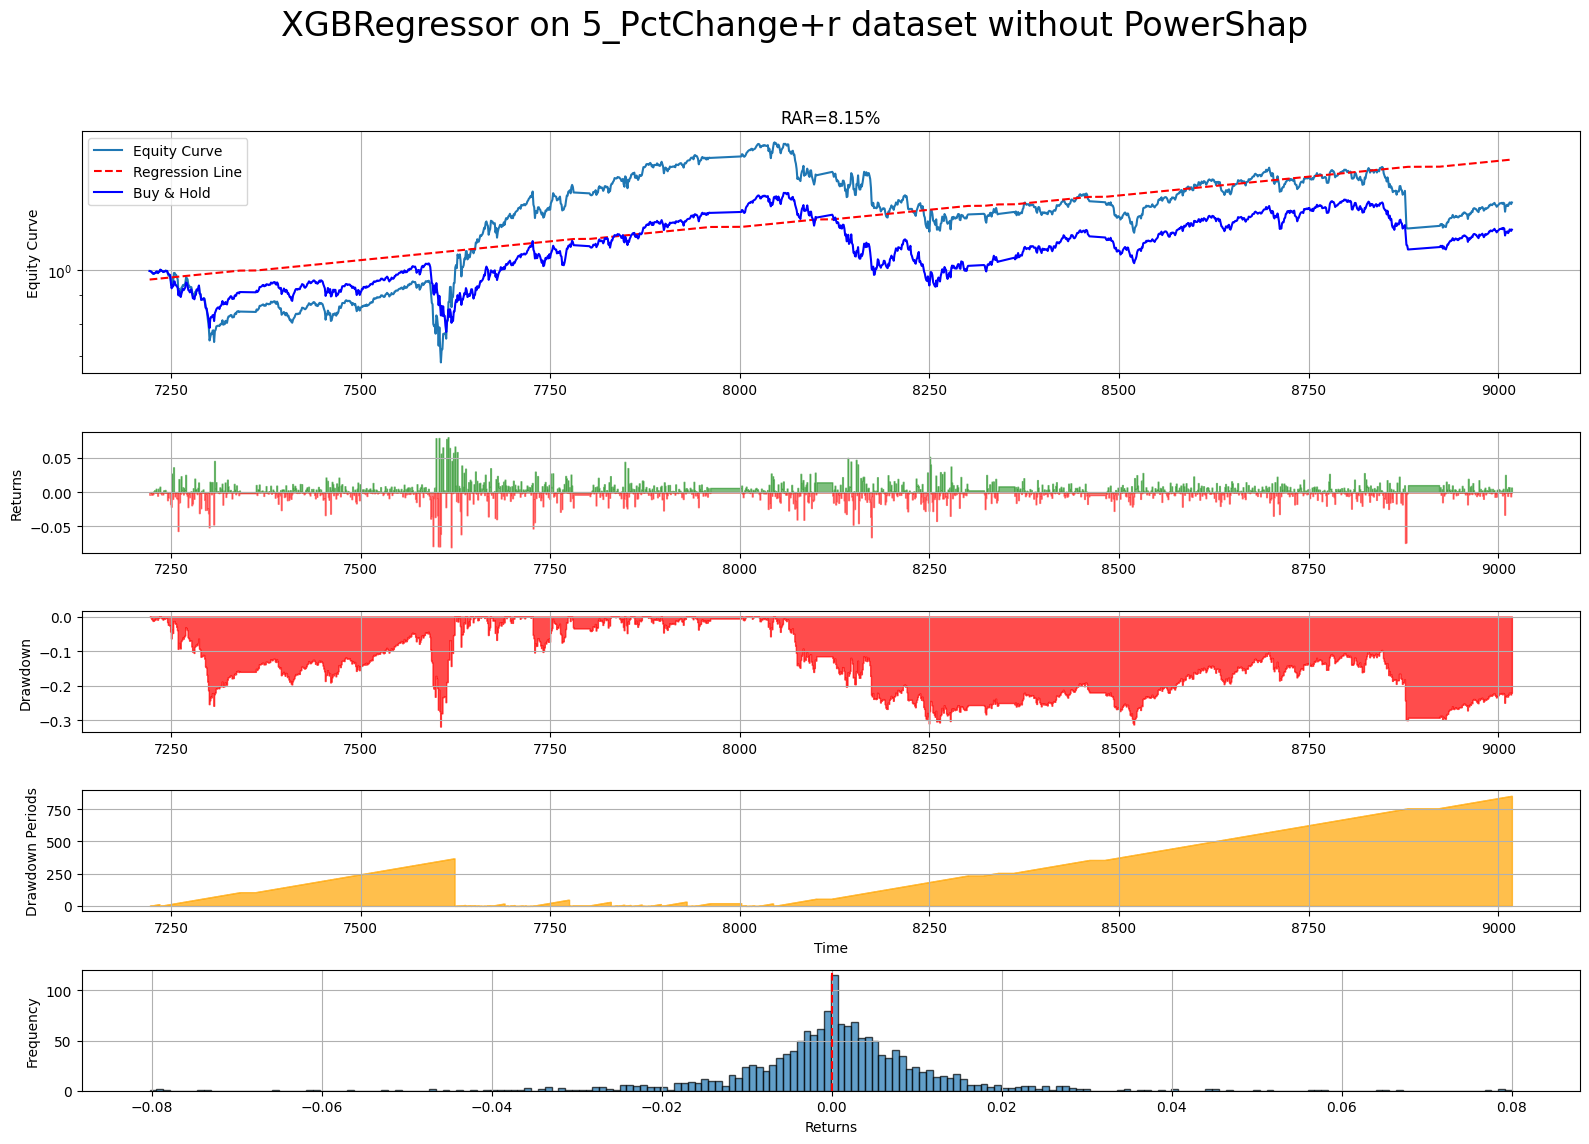

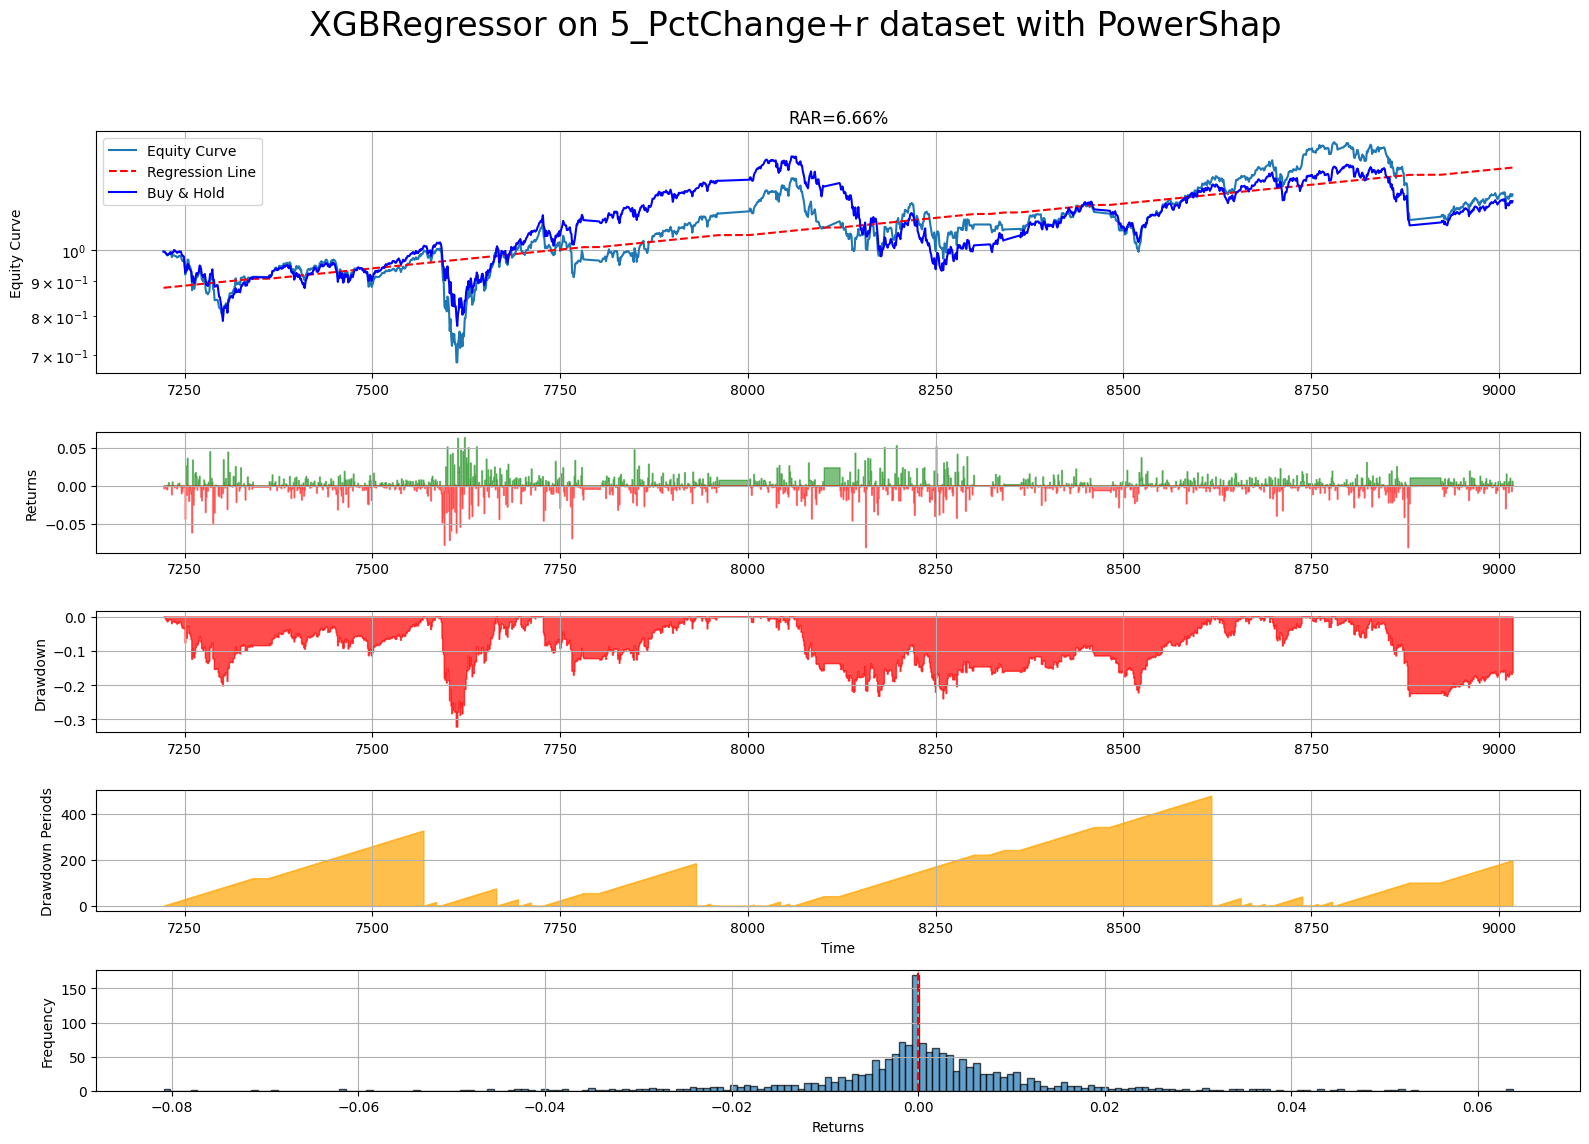

In [10]:
TRADING_PERIOD = 252
scores = {}
metrics_dfs = {}
for name, dataset in all_datasets.items():
    for model in [linear_reg, xgb]:
        params = dict(
            dataset_name=name,
            window=WINDOW,
            delta=DELTA,
            h=H,
            model=model
        )
        key = (model.__class__.__name__, name)
        base_score, ps_score = evaluate(**params)
        scores[key] = (base_score, ps_score)
        plot_results(**params)
        # plot_feature_impacts(**params)
        
        index, y_true, base_pred, ps_pred = get_pred_csv(**params)
        times = index.to_numpy()
        buy_hold = y_true.to_numpy()
        buy_hold_equity_curve = np.cumprod(1 + buy_hold)
        metrics_dfs[key] = (
            analyze_returns(
                returns=convert_ret_to_signal(base_pred.fill_null(0).to_numpy())*buy_hold,
                times=times,
                trading_period=TRADING_PERIOD,
                buy_hold=buy_hold_equity_curve,
                title=f"{model.__class__.__name__} on {name} dataset without PowerShap"
            ),
            analyze_returns(
                returns=convert_ret_to_signal(ps_pred.fill_null(0).to_numpy())*buy_hold,
                times=times,
                trading_period = TRADING_PERIOD,
                buy_hold=buy_hold_equity_curve,
                title=f"{model.__class__.__name__} on {name} dataset with PowerShap"
            )
        )

In [11]:
multi_index = pd.MultiIndex.from_product([('LinearRegression', 'XGBRegressor'), ('No', 'Yes')], names=['Model', 'Variable selection'])
columns = list(all_datasets.keys())
rmse_matrix = [
    [scores[('LinearRegression', ds_name)][0] for ds_name in columns],
    [scores[('LinearRegression', ds_name)][1] for ds_name in columns],
    [scores[('XGBRegressor', ds_name)][0] for ds_name in columns],
    [scores[('XGBRegressor', ds_name)][1] for ds_name in columns]
]
rmse_df = pd.DataFrame(data=rmse_matrix, index=multi_index, columns=columns)
rmse_df


1_Original_x  2_PctChange_Δx  \
Model            Variable selection                                 
LinearRegression No                      0.019847        0.268335   
                 Yes                     0.015932        0.039333   
XGBRegressor     No                      0.011789        0.011564   
                 Yes                     0.012662        0.012118   

                                     3_Historical_r  4_Original+r  \
Model            Variable selection                                 
LinearRegression No                        0.013497      0.026970   
                 Yes                       0.011716      0.014763   
XGBRegressor     No                        0.012544      0.012091   
                 Yes                       0.013496      0.012982   

                                     5_PctChange+r  
Model            Variable selection                 
LinearRegression No                       0.273136  
                 Yes                      0.040431  
XGBRegressor     No                       0.011813  
                 Yes                      0.012753

In [13]:
sr_matrix = [
    [metrics_dfs[('LinearRegression', ds_name)][0].at['Sharpe Ratio', 'Value'] for ds_name in columns],
    [metrics_dfs[('LinearRegression', ds_name)][1].at['Sharpe Ratio', 'Value'] for ds_name in columns],
    [metrics_dfs[('XGBRegressor', ds_name)][0].at['Sharpe Ratio', 'Value'] for ds_name in columns],
    [metrics_dfs[('XGBRegressor', ds_name)][1].at['Sharpe Ratio', 'Value'] for ds_name in columns],
]
sr_df = pd.DataFrame(data=sr_matrix, index=multi_index, columns=columns)
sr_df

1_Original_x 2_PctChange_Δx  \
Model            Variable selection                               
LinearRegression No                         0.40          -0.03   
                 Yes                        0.50           0.34   
XGBRegressor     No                         0.46           0.39   
                 Yes                        0.12           0.52   

                                    3_Historical_r 4_Original+r 5_PctChange+r  
Model            Variable selection                                            
LinearRegression No                           0.06         0.24          0.27  
                 Yes                          0.06         0.24          0.13  
XGBRegressor     No                           0.36         0.31          0.31  
                 Yes                          0.01         0.36          0.25